In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp

import pysindy as ps

import os

from get_model import getmodel
from compare_center_not_show import cmp_center

import math  
import sys  
sys.path.append('C:/Users/j/hotai/myfolder')

from my_function import miscore, siscore
# Ignore matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Seed the random number generators for reproducibility   sr_C1_20  sr_C4_12
np.random.seed(100)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

addp=5
startp=90
endp=120
dp=endp-startp
p_tot=addp*(dp-1)+1
file_tot=100
n=25
xstart=0
xend=25

In [2]:
def read_data(file_path,file_name,n,file_start=0,file_end=0,xstart=0,xend=0):
    x=np.zeros((121,n,n))
    y=np.zeros((121,n,n))
    vx=np.zeros((121,n,n))
    vy=np.zeros((121,n,n))
    #file_tot=file_end-file_start
    for i in range(file_start,file_end):
        xp=[]
        yp=[]
        vxp=[]
        vyp=[]
        isvalid=[]
        xtmp=[]
        ytmp=[]
        vxtmp=[]
        vytmp=[]
        isvalidtmp=[]
        
        for root,dirs,files in os.walk(file_path):
            #print(root)
            
            for dir in dirs:
                #print(os.path.join(root,file))
                
    
                    with open(os.path.join(root,dir,file_name[i]), 'r') as f:  
                        lines = f.readlines()
                        for line in lines[3:]: 
                            num=line.split()
                            xtmp.append(float(num[0]))
                            ytmp.append(float(num[1]))
                            vxtmp.append(float(num[2]))
                            vytmp.append(float(num[3]))
                            isvalidtmp.append(float(num[4]))
        
                    xp.append(np.array(xtmp).reshape(25,25))
                    yp.append(np.array(ytmp).reshape(25,25))
                    vxp.append(np.array(vxtmp).reshape(25,25))
                    vyp.append(np.array(vytmp).reshape(25,25))
                    isvalid.append(np.array(isvalidtmp).reshape(25,25))
                    xtmp=[]
                    ytmp=[]
                    vxtmp=[]
                    vytmp=[]
                    isvalidtmp=[]
        #
        xp=np.array(xp)
        yp=np.array(yp)
        vxp=np.array(vxp)
        vyp=np.array(vyp)
        isvalid=np.array(isvalid)
        x=x+xp/file_tot
        y=y+yp/file_tot
        vx=vx+vxp/file_tot
        vy=vy+vyp/file_tot
    x=x.T
    x=x[xstart:xend,xstart:xend]
    y=y.T
    y=y[xstart:xend,xstart:xend]
    vx=vx.T
    vx=vx[xstart:xend,xstart:xend]
    vy=vy.T
    vy=vy[xstart:xend,xstart:xend]
    isvalid=isvalid.T
    isvalid=isvalid[xstart:xend,xstart:xend]
    return x,y,vx,vy

In [3]:
file_path = os.path.join('D:\\', 'hotaidata','sr_C6_01')
file_name=['B00001.dat','B00002.dat','B00003.dat','B00004.dat','B00005.dat','B00006.dat','B00007.dat','B00008.dat',
           'B00009.dat','B00010.dat','B00011.dat','B00012.dat','B00013.dat','B00014.dat','B00015.dat','B00016.dat','B00017.dat',
           'B00018.dat','B00019.dat','B00020.dat','B00021.dat','B00022.dat','B00023.dat','B00024.dat','B00025.dat','B00026.dat',
           'B00027.dat','B00028.dat','B00029.dat','B00030.dat','B00031.dat','B00032.dat','B00033.dat','B00034.dat','B00035.dat',
           'B00036.dat','B00037.dat','B00038.dat','B00039.dat','B00040.dat','B00041.dat','B00042.dat','B00043.dat','B00044.dat',
           'B00045.dat','B00046.dat','B00047.dat','B00048.dat','B00049.dat','B00050.dat','B00051.dat','B00052.dat','B00053.dat',
           'B00054.dat','B00055.dat','B00056.dat','B00057.dat','B00058.dat','B00059.dat','B00060.dat','B00061.dat','B00062.dat',
           'B00063.dat','B00064.dat','B00065.dat','B00066.dat','B00067.dat','B00068.dat','B00069.dat','B00070.dat','B00071.dat',
           'B00072.dat','B00073.dat','B00074.dat','B00075.dat','B00076.dat','B00077.dat','B00078.dat','B00079.dat','B00080.dat',
           'B00081.dat','B00082.dat','B00083.dat','B00084.dat','B00085.dat','B00086.dat','B00087.dat','B00088.dat','B00089.dat',
           'B00090.dat','B00091.dat','B00092.dat','B00093.dat','B00094.dat','B00095.dat','B00096.dat','B00097.dat','B00098.dat',
           'B00099.dat','B00100.dat']
x=np.zeros((n,n,121))
y=np.zeros((n,n,121))
vx=np.zeros((n,n,121))
vy=np.zeros((n,n,121))

#print(x[0,:,:])

In [4]:
#u is not pre adding, v add a median

x,y,vx,vy=read_data(file_path,file_name,25,0,50,xstart,xend)

spatial_grid = np.asarray([x[:,:,0].T,y[:,:,0].T]).T

n=xend-xstart

u=np.zeros((n,n,121, 3))
u[:, :, :, 0] = vx
u[:, :, :, 1] = vy

t=np.linspace(0,60/800,121)

t_in=np.zeros((n,n,121))
for i in range (len(t)):
    t_in[:,:,i]=t[i]

u[:, :, :, 2] = t_in

dt=t[1]-t[0]

t_adding=np.linspace(t[0],t[-1],addp*(len(t)-1)+1)
print(t_adding.shape)
dt_adding=t_adding[1]-t_adding[0]

u_train=np.zeros((n,n,len(t_adding),3))

for i in range(len(t)-1):
    for j in range(addp):
        u_train[:,:,addp*i+j]=(u[:,:,i]*(addp-j)+u[:,:,i+1]*j)/addp
u_train[:,:,-1]=u[:,:,-1]


(601,)


In [5]:
# import test data
x_test,y_test,vx_test,vy_test=read_data(file_path,file_name,25,51,100,xstart,xend)
ut=np.zeros((n,n,121, 3))

ut[:, :, :, 0] = vx_test
ut[:, :, :, 1] = vy_test
ut[:, :, :, 2] = t_in

u_test=np.zeros((n,n,len(t_adding), 3))

for i in range(len(t)-1):
    for j in range(addp):
        u_test[:,:,addp*i+j]=(ut[:,:,i]*(addp-j)+ut[:,:,i+1]*j)/addp
u_test[:,:,-1]=ut[:,:,-1]

si_t=np.zeros(p_tot)
mi_t=np.zeros(p_tot)
si_t_per=np.zeros(p_tot)
mi_t_per=np.zeros(p_tot)

round: 0
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 1175.108 1 + 78.637 Vx + 183.525 Vy + -54173.370 t + 19.365 VxVx + -6.422 VyVy + 615776.255 tt + 5.134 VxVy + -875.640 Vxt + -3422.204 Vyt + 0.770 VxVxVy + -305.133 VxVxt + 202.599 VyVyt + -209.568 VxVyt + 3182.891 Vx_2 + 595.268 Vy_2 + 804.896 Vx_1 + -462.673 Vy_1 + 208.732 VxVx_2 + -183.089 VxVy_2 + -143392.033 Vxt_2 + 50.247 VyVx_2 + -29.639 VyVy_2 + 1595221.458 Vyt_2 + 0.230 tVx_2 + -4740.313 tVy_2 + 3054.790 tt_2 + -0.031 VxVxVx_2 + -1098.050 VxVxVy_2 + 454.535 VxVxt_2 + 167.812 VyVyVx_2 + 23.212 VyVyVy_2 + -34.172 VyVyt_2 + -27532.695 ttVx_2 + -49.628 ttVy_2 + -12.089 ttt_2 + 312081.401 VxVyVx_2 + -16.751 VxVyVy_2 + 206.759 VxVyt_2 + 559.769 VxtVx_2 + 1.323 VxtVy_2 + 820.003 Vxtt_2 + 256.925 VytVx_2 + 581.558 VytVy_2 + -264.264 VxVx_1 + 35.780 VxVy_1 + -36891.454 Vxt_1 + -75.626 VyVx_1 + -35.322 VyVy_1 + 416083.034 Vyt_1 + 53.938 tVx_1 + 5212.506 tVy_1 + -2238.921 tt_1 + -1.477 VxVxVx_1 + 1607.606 VxVxVy_1 + 918.477 VxVxt_1 + -1401.8

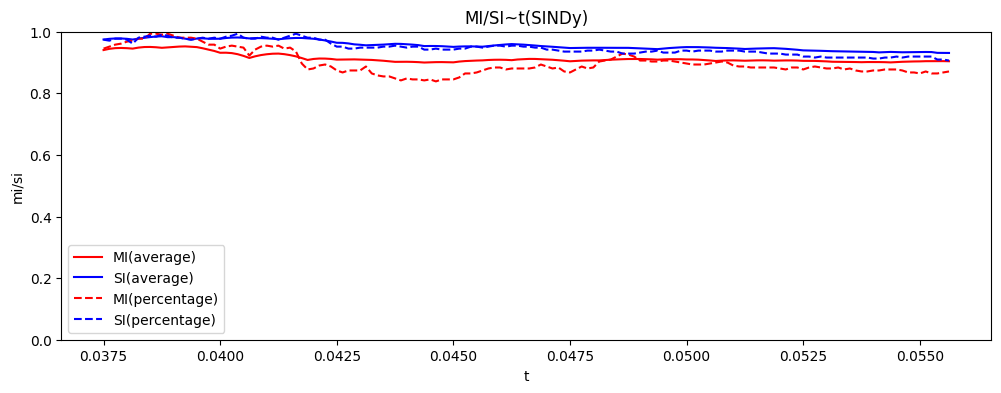

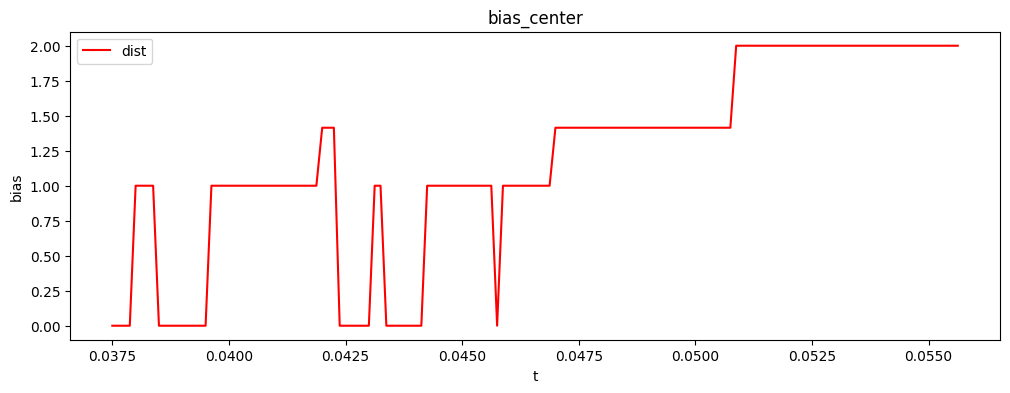

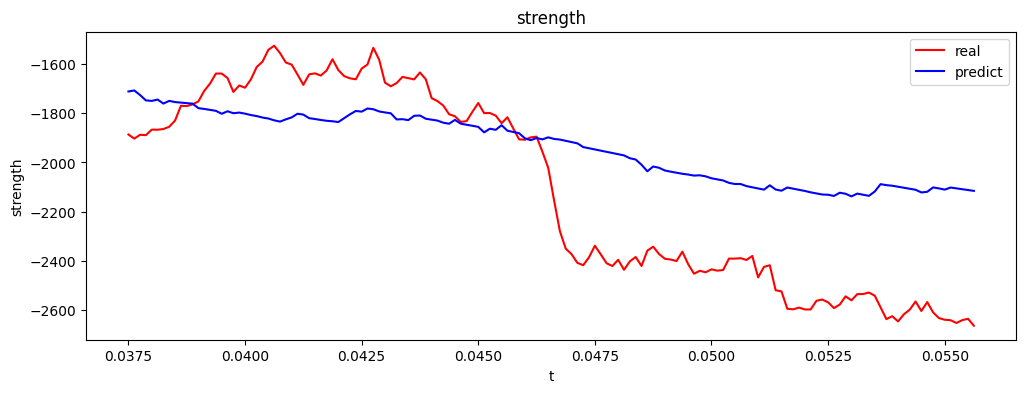

round: 1
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 360.685 1 + 87.236 Vx + 129.360 Vy + -19613.654 t + 38.814 VxVx + -3.708 VyVy + 251938.380 tt + 34.795 VxVy + -1111.900 Vxt + -2401.253 Vyt + 1.595 VxVxVy + -723.128 VxVxt + 152.371 VyVyt + -805.117 VxVyt + 1939.695 Vx_2 + 2259.474 Vy_2 + 456.007 Vx_1 + 67.342 Vy_1 + 66.579 VxVx_2 + -189.950 VxVy_2 + -89963.568 Vxt_2 + 20.611 VyVx_2 + 8.114 VyVy_2 + 1025297.567 Vyt_2 + -94.651 tVx_2 + -1691.258 tVy_2 + 3305.452 tt_2 + -1.127 VxVxVx_2 + -467.517 VxVxVy_2 + -331.932 VxVxt_2 + 2140.479 VyVyVx_2 + 10.739 VyVyVy_2 + 47.083 VyVyt_2 + -98753.234 ttVx_2 + 30.941 ttVy_2 + -5.587 ttt_2 + 1065565.926 VxVyVx_2 + -34.259 VxVyVy_2 + 748.408 VxVyt_2 + -1125.103 VxtVx_2 + 0.638 VxtVy_2 + -898.461 Vxtt_2 + 137.384 VytVx_2 + 911.708 VytVy_2 + -205.660 VxVx_1 + 275.713 VxVy_1 + -21198.827 Vxt_1 + -58.094 VyVx_1 + -97.415 VyVy_1 + 243379.896 Vyt_1 + 61.998 tVx_1 + 3641.879 tVy_1 + -6991.448 tt_1 + -2.059 VxVxVx_1 + 1154.418 VxVxVy_1 + 2108.099 VxVxt_1 + -1622

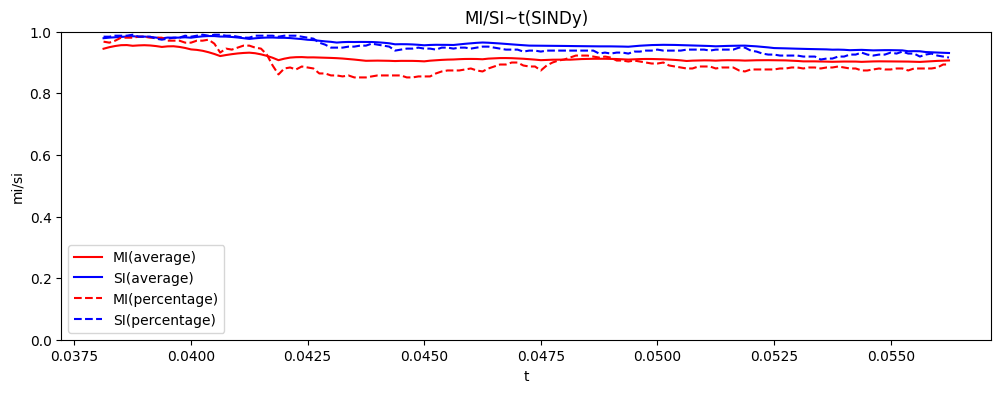

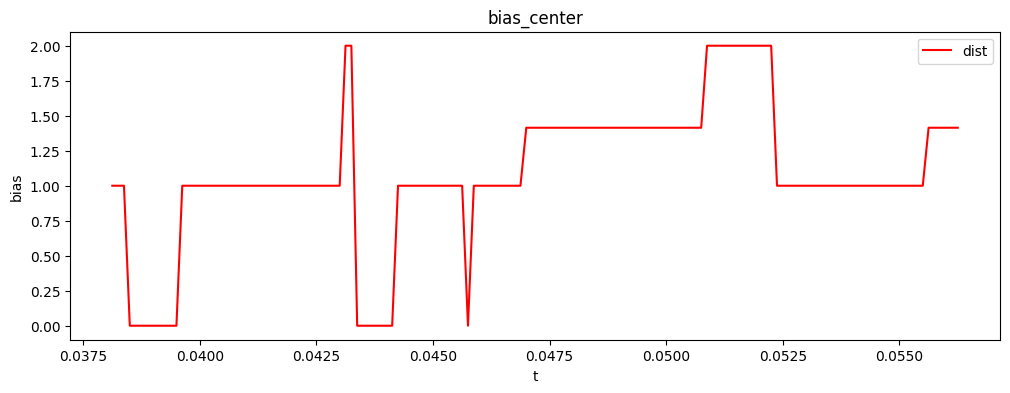

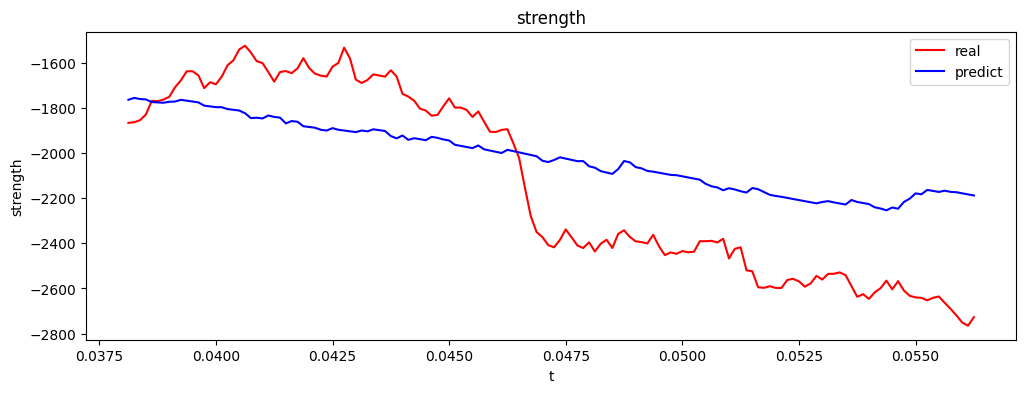

round: 2
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 10.510 1 + 181.047 Vx + 135.534 Vy + -3951.926 t + 68.669 VxVx + 19.480 VyVy + 79453.992 tt + 26.206 VxVy + -3047.289 Vxt + -2412.698 Vyt + -1302.580 VxVxt + -304.293 VyVyt + -637.777 VxVyt + 1497.138 Vx_2 + 734.391 Vy_2 + 1548.280 Vx_1 + 327.295 Vy_1 + 217.006 VxVx_2 + -125.861 VxVy_2 + -70849.147 Vxt_2 + 52.227 VyVx_2 + -71.155 VyVy_2 + 820506.324 Vyt_2 + -94.391 tVx_2 + -4640.340 tVy_2 + 1853.591 tt_2 + 0.336 VxVxVx_2 + -1083.179 VxVxVy_2 + 1243.747 VxVxt_2 + 2110.811 VyVyVx_2 + -15.488 VyVyVy_2 + 7.372 VyVyt_2 + -32807.234 ttVx_2 + 46.567 ttVy_2 + -6.969 ttt_2 + 361664.376 VxVyVx_2 + 64.691 VxVyVy_2 + 953.811 VxVyt_2 + -226.374 VxtVx_2 + 0.037 VxtVy_2 + -1097.268 Vxtt_2 + 140.518 VytVx_2 + -1047.112 VytVy_2 + -53.568 VxVx_1 + 305.417 VxVy_1 + -67122.894 Vxt_1 + -20.508 VyVx_1 + -67.502 VyVy_1 + 720191.438 Vyt_1 + 1026.482 tVy_1 + -7559.721 tt_1 + -1.287 VxVxVx_1 + 489.218 VxVxVy_1 + 1518.703 VxVxt_1 + -302.759 VyVyVx_1 + -283.449 VyVyV

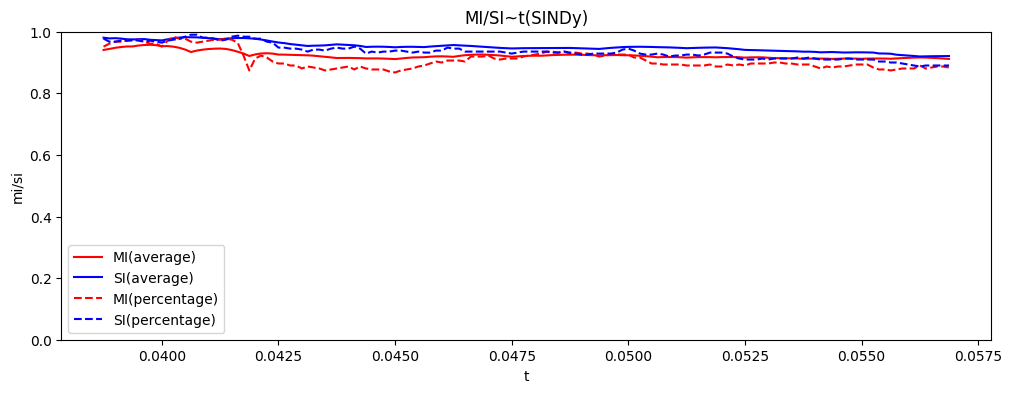

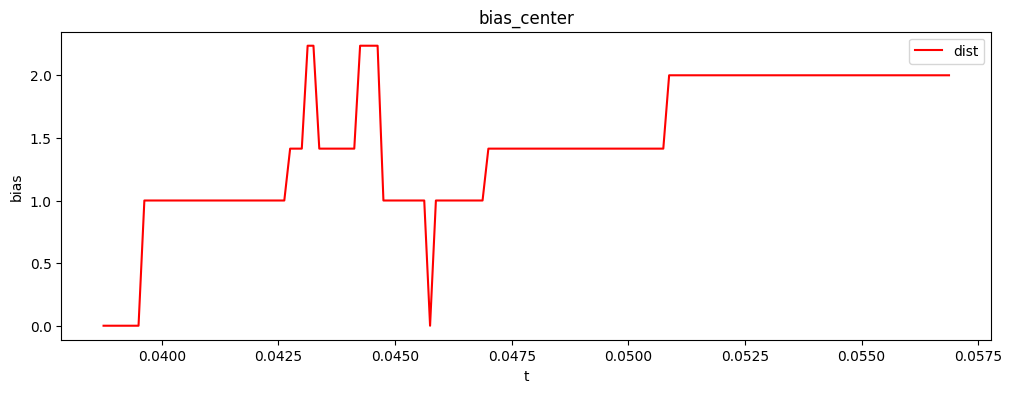

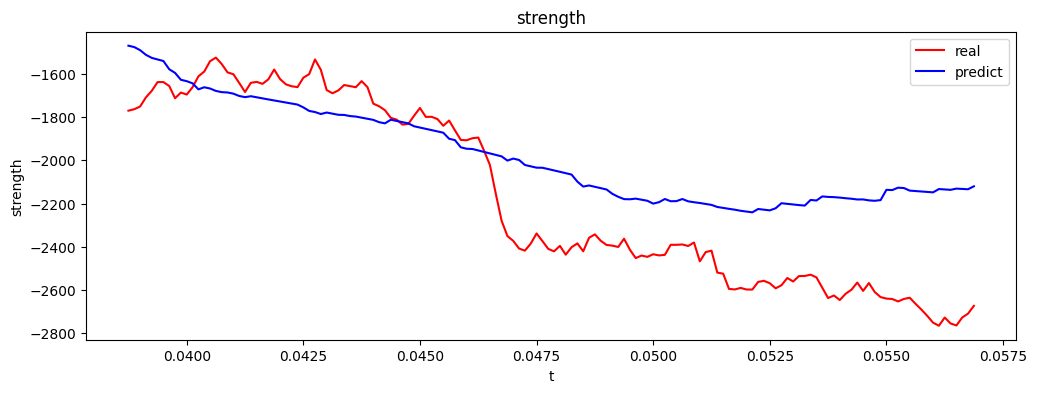

round: 3
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 53.577 1 + 147.411 Vx + 106.948 Vy + -5278.658 t + 33.791 VxVx + -1.186 VyVy + 88618.063 tt + -3.863 VxVy + -2341.862 Vxt + -1708.947 Vyt + -0.616 VxVxVy + -600.851 VxVxt + 114.468 VyVyt + -16.202 VxVyt + 281.889 Vx_2 + -2322.377 Vy_2 + -216.393 Vx_1 + 64.949 Vy_1 + 227.906 VxVx_2 + 50.327 VxVy_2 + -17861.462 Vxt_2 + 36.043 VyVx_2 + -34.031 VyVy_2 + 251686.437 Vyt_2 + -41.715 tVx_2 + -4928.188 tVy_2 + -1893.542 tt_2 + 0.978 VxVxVx_2 + -778.209 VxVxVy_2 + 484.787 VxVxt_2 + 1064.093 VyVyVx_2 + -233.769 VyVyVy_2 + -39.052 VyVyt_2 + 93965.325 ttVx_2 + -30.006 ttVy_2 + 0.684 ttt_2 + -939439.128 VxVyVx_2 + 14.735 VxVyVy_2 + 5358.725 VxVyt_2 + 718.351 VxtVx_2 + 0.284 VxtVy_2 + 444.063 Vxtt_2 + -21.107 VytVx_2 + -16.862 VytVy_2 + -162.416 VxVx_1 + 47.490 VxVy_1 + 7528.143 Vxt_1 + -58.332 VyVx_1 + -59.431 VyVy_1 + -59889.506 Vyt_1 + -50.836 tVx_1 + 3004.396 tVy_1 + -2343.691 tt_1 + -1.217 VxVxVx_1 + 1200.839 VxVxVy_1 + 1331.875 VxVxt_1 + 809.447 Vy

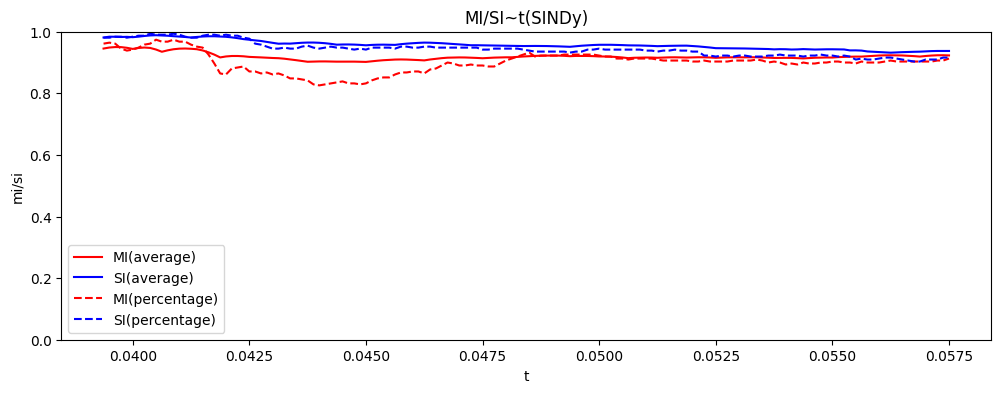

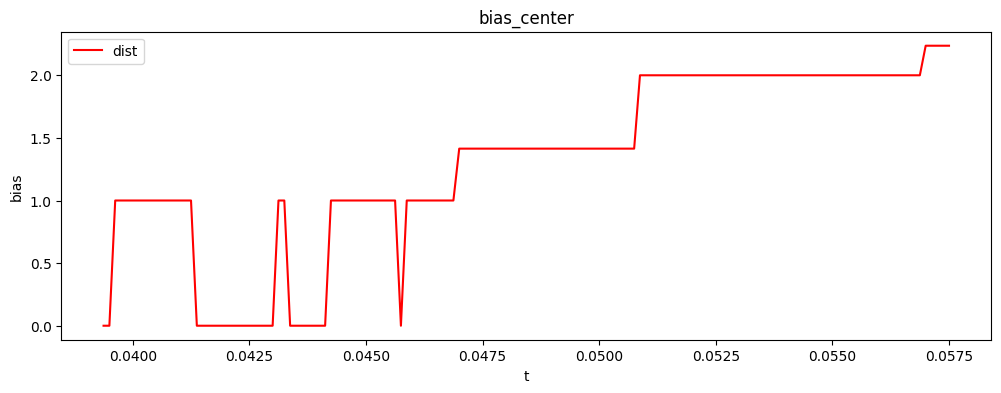

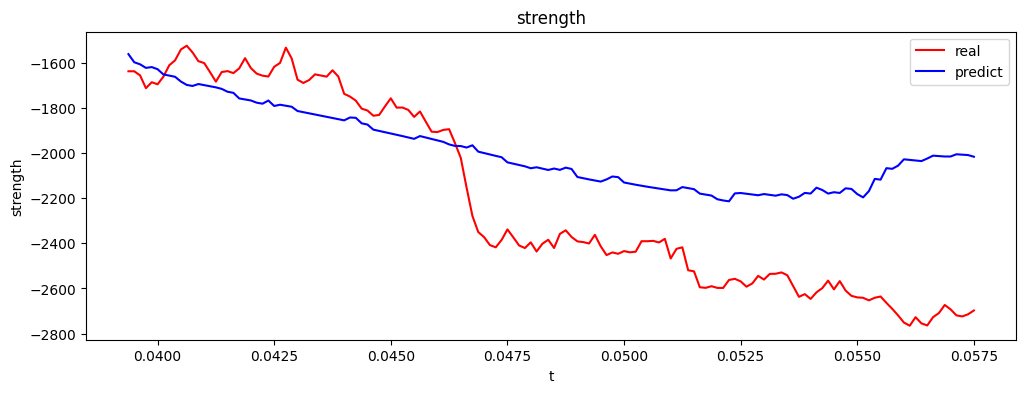

round: 4
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -532.697 1 + 226.836 Vx + 156.146 Vy + 18970.741 t + 52.535 VxVx + 14.452 VyVy + -159870.856 tt + 11.740 VxVy + -3982.544 Vxt + -2737.265 Vyt + -973.282 VxVxt + -204.912 VyVyt + -286.046 VxVyt + -1270.161 Vx_2 + -1549.861 Vy_2 + -640.899 Vx_1 + 340.525 Vy_1 + 307.443 VxVx_2 + -152.968 VxVy_2 + 43752.040 Vxt_2 + 66.115 VyVx_2 + -53.500 VyVy_2 + -356006.048 Vyt_2 + -46.478 tVx_2 + -6582.844 tVy_2 + 2130.636 tt_2 + 1.064 VxVxVx_2 + -1388.452 VxVxVy_2 + 890.669 VxVxt_2 + 1079.172 VyVyVx_2 + -6.370 VyVyVy_2 + 13.631 VyVyt_2 + 63274.578 ttVx_2 + 4.803 ttVy_2 + -3.589 ttt_2 + -637604.143 VxVyVx_2 + 69.621 VxVyVy_2 + 1042.785 VxVyt_2 + -384.759 VxtVx_2 + 1.575 VxtVy_2 + -226.624 Vxtt_2 + 67.128 VytVx_2 + -1149.822 VytVy_2 + -138.761 VxVx_1 + 78.751 VxVy_1 + 27008.075 Vxt_1 + -39.150 VyVx_1 + -92.769 VyVy_1 + -276903.619 Vyt_1 + -51.936 tVx_1 + 2882.099 tVy_1 + -2834.247 tt_1 + -1.319 VxVxVx_1 + 858.416 VxVxVy_1 + 1981.922 VxVxt_1 + 730.650 VyVyVx_

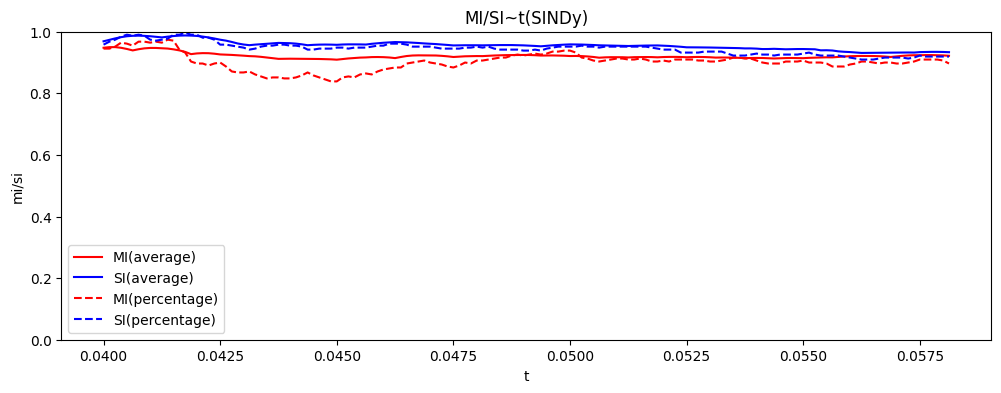

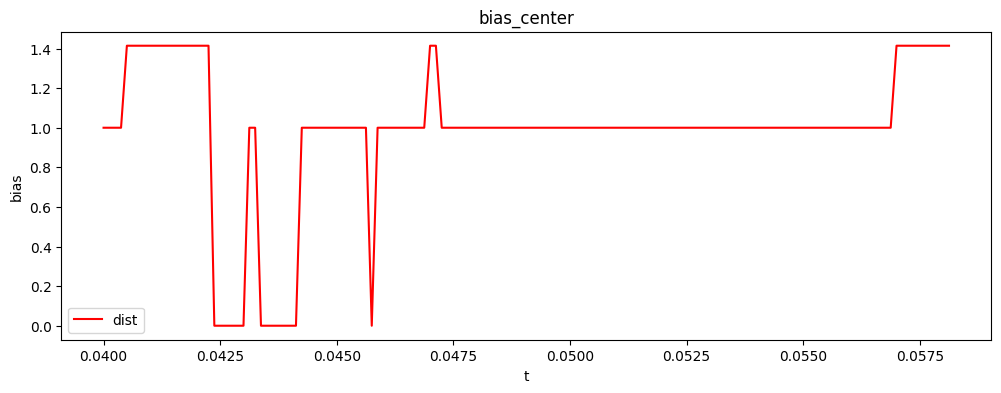

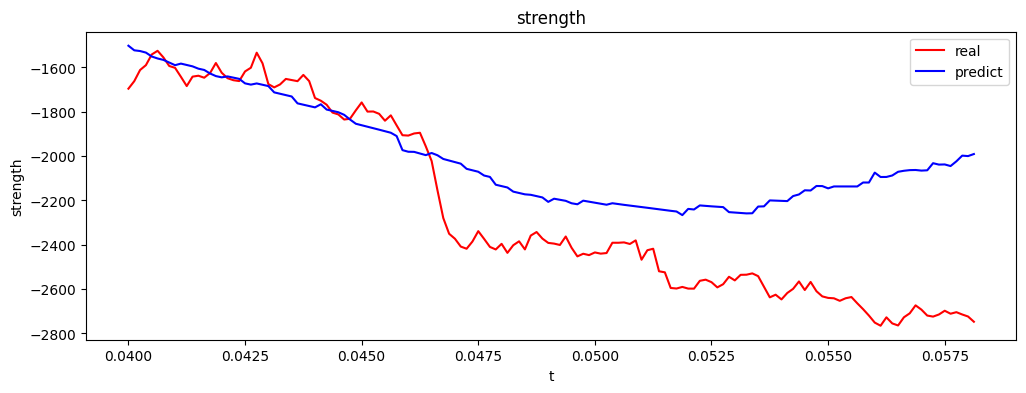

round: 5
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -921.128 1 + 233.287 Vx + 141.451 Vy + 35104.564 t + 59.428 VxVx + 12.873 VyVy + -325779.736 tt + -3.325 VxVy + -4031.941 Vxt + -2401.860 Vyt + -0.925 VxVxVy + -1096.671 VxVxt + -178.695 VyVyt + -29.675 VxVyt + -1821.766 Vx_2 + -1848.015 Vy_2 + 1331.269 Vx_1 + 84.161 Vy_1 + 132.933 VxVx_2 + -87.112 VxVy_2 + 67706.038 Vxt_2 + 27.137 VyVx_2 + -60.152 VyVy_2 + -612059.944 Vyt_2 + -9.392 tVx_2 + -3025.646 tVy_2 + 914.168 tt_2 + 0.773 VxVxVx_2 + -599.116 VxVxVy_2 + 1012.805 VxVxt_2 + 389.741 VyVyVx_2 + 23.548 VyVyVy_2 + -65.093 VyVyt_2 + 72624.615 ttVx_2 + -10.826 ttVy_2 + 6.247 ttt_2 + -704402.219 VxVyVx_2 + 65.206 VxVyVy_2 + 245.723 VxVyt_2 + 1199.193 VxtVx_2 + 0.695 VxtVy_2 + 79.067 Vxtt_2 + -126.382 VytVx_2 + -1038.131 VytVy_2 + -18.638 VxVx_1 + 113.153 VxVy_1 + -53346.273 Vxt_1 + -17.236 VyVx_1 + -77.634 VyVy_1 + 531777.073 Vyt_1 + -98.874 tVx_1 + 397.237 tVy_1 + -3610.976 tt_1 + -0.786 VxVxVx_1 + 423.443 VxVxVy_1 + 1711.058 VxVxt_1 + 1784

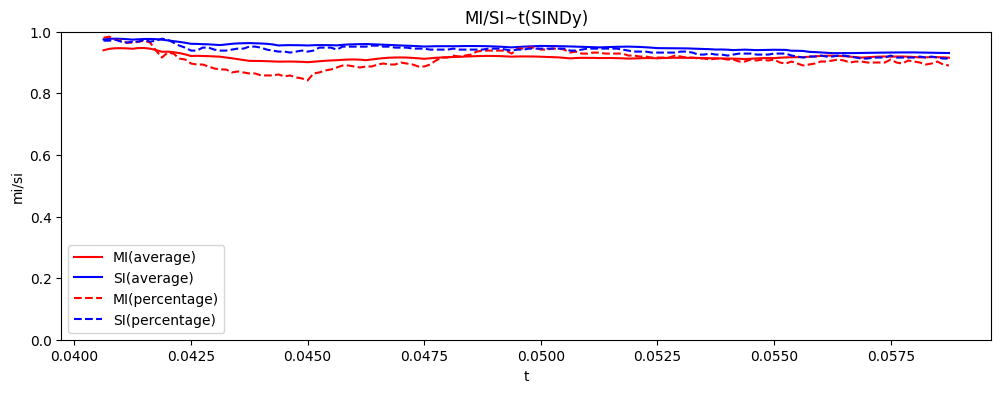

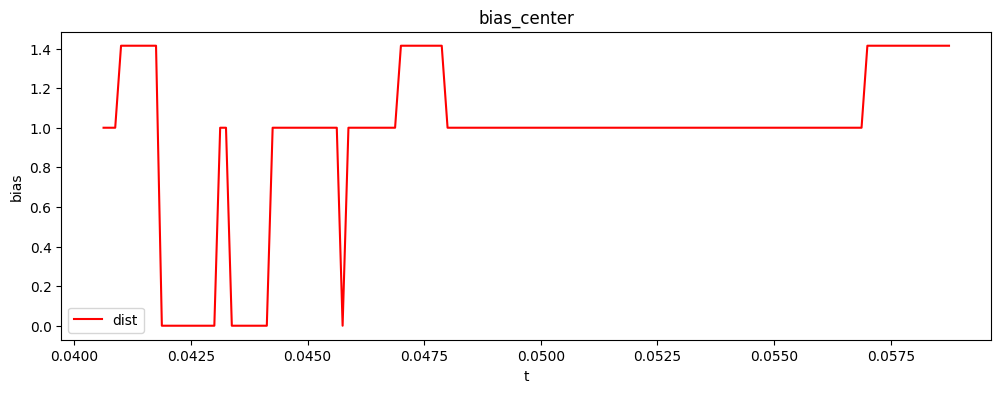

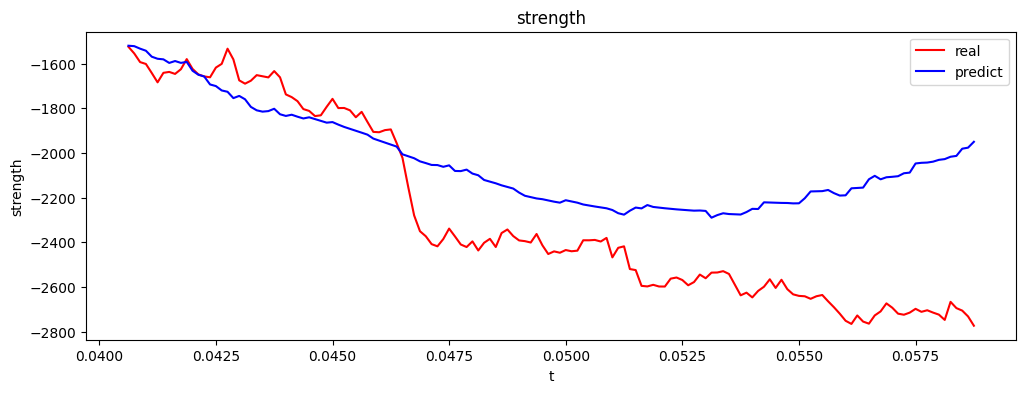

round: 6
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -355.403 1 + 311.878 Vx + 42.134 Vy + 12635.014 t + 75.713 VxVx + 25.818 VyVy + -105395.865 tt + -11.014 VxVy + -5423.488 Vxt + -341.770 Vyt + -1.043 VxVxVy + -1379.305 VxVxt + -423.016 VyVyt + 141.190 VxVyt + -3138.761 Vx_2 + -2670.826 Vy_2 + -1002.864 Vx_1 + -207.323 Vy_1 + 146.476 VxVx_2 + 107.742 VxVy_2 + 119702.630 Vxt_2 + 35.223 VyVx_2 + -80.773 VyVy_2 + -1120260.749 Vyt_2 + -29.168 tVx_2 + -3091.280 tVy_2 + -3122.725 tt_2 + 1.080 VxVxVx_2 + -725.825 VxVxVy_2 + 1385.174 VxVxt_2 + 696.824 VyVyVx_2 + -156.122 VyVyVy_2 + -11.682 VyVyt_2 + 103418.958 ttVx_2 + 40.784 ttVy_2 + 0.847 ttt_2 + -989271.125 VxVyVx_2 + 92.478 VxVyVy_2 + 3987.534 VxVyt_2 + 167.125 VxtVx_2 + 0.972 VxtVy_2 + -856.750 Vxtt_2 + -26.201 VytVx_2 + -1531.682 VytVy_2 + -74.158 VxVx_1 + -92.643 VxVy_1 + 37369.298 Vxt_1 + -6.926 VyVx_1 + -24.740 VyVy_1 + -341990.865 Vyt_1 + -171.670 tVx_1 + 1419.328 tVy_1 + 320.975 tt_1 + -0.492 VxVxVx_1 + 196.473 VxVxVy_1 + 650.857 VxVxt_

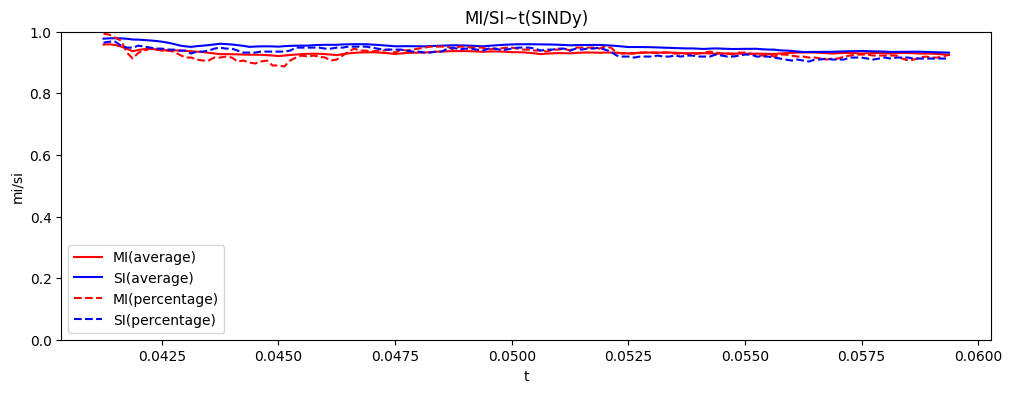

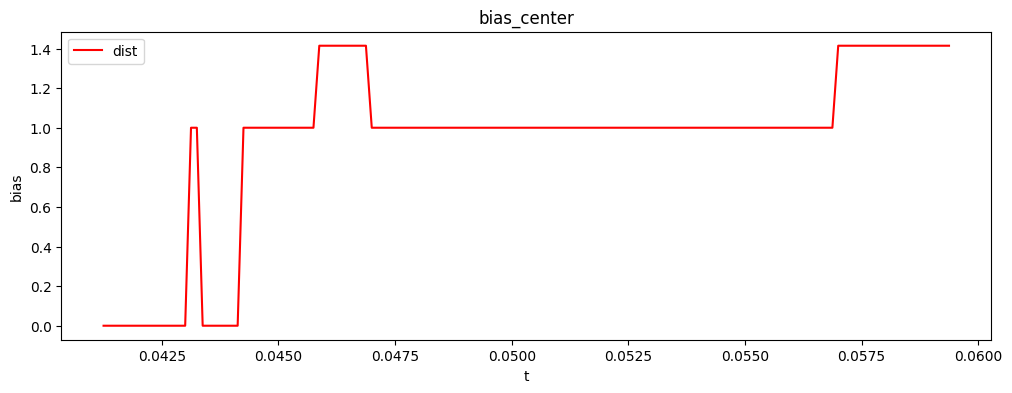

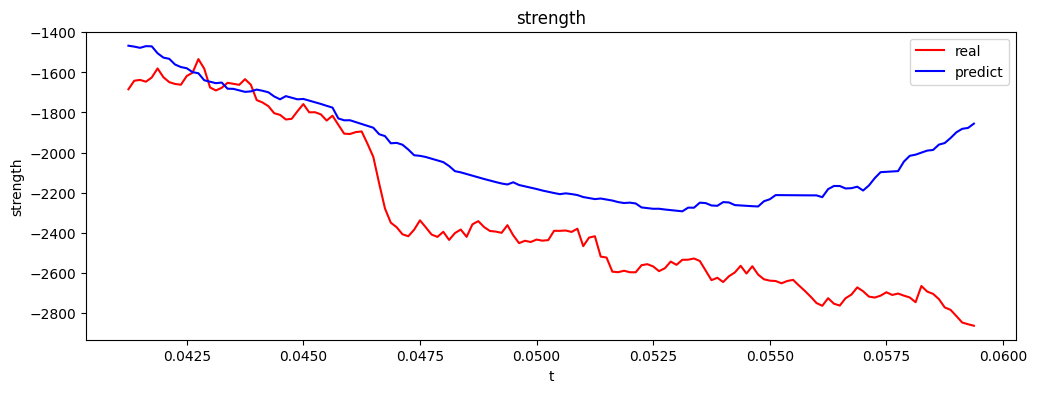

round: 7
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -526.870 1 + 261.332 Vx + 62.484 Vy + 19918.833 t + 77.595 VxVx + 39.332 VyVy + -182100.716 tt + -19.219 VxVy + -4385.672 Vxt + -726.387 Vyt + -0.985 VxVxVy + -1399.748 VxVxt + -711.984 VyVyt + 247.859 VxVyt + -2634.569 Vx_2 + -2871.999 Vy_2 + -2104.880 Vx_1 + 211.111 Vy_1 + -3.616 VxVx_2 + 117.091 VxVy_2 + 101307.949 Vxt_2 + 10.208 VyVx_2 + -121.310 VyVy_2 + -955609.303 Vyt_2 + -21.686 tVx_2 + -226.595 tVy_2 + -3168.650 tt_2 + 0.925 VxVxVx_2 + -253.620 VxVxVy_2 + 2209.378 VxVxt_2 + 585.864 VyVyVx_2 + -152.032 VyVyVy_2 + -37.661 VyVyt_2 + 111575.781 ttVx_2 + 51.240 ttVy_2 + -5.645 ttt_2 + -1070918.817 VxVyVx_2 + 142.452 VxVyVy_2 + 3883.885 VxVyt_2 + 614.304 VxtVx_2 + 1.737 VxtVy_2 + -1149.468 Vxtt_2 + 105.605 VytVx_2 + -2540.124 VytVy_2 + -119.705 VxVx_1 + -37.066 VxVy_1 + 81545.325 Vxt_1 + -13.800 VyVx_1 + -12.557 VyVy_1 + -780525.224 Vyt_1 + -195.019 tVx_1 + 2356.535 tVy_1 + -899.830 tt_1 + 0.286 VxVxVx_1 + 315.245 VxVxVy_1 + 491.223 VxV

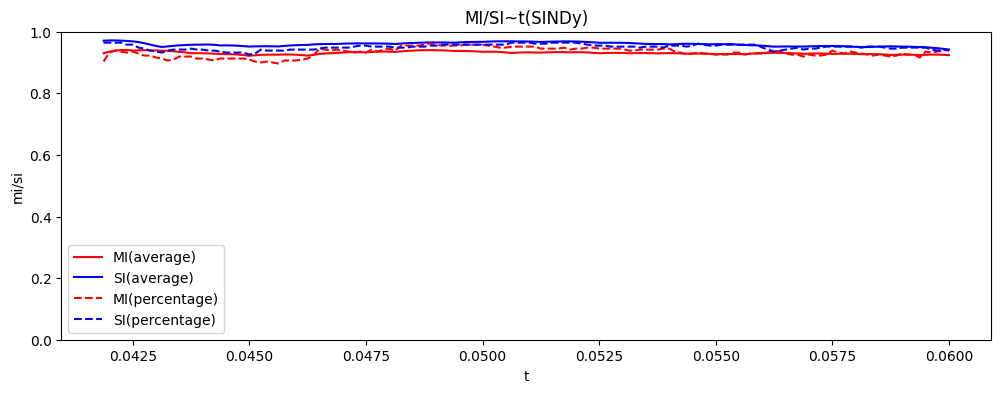

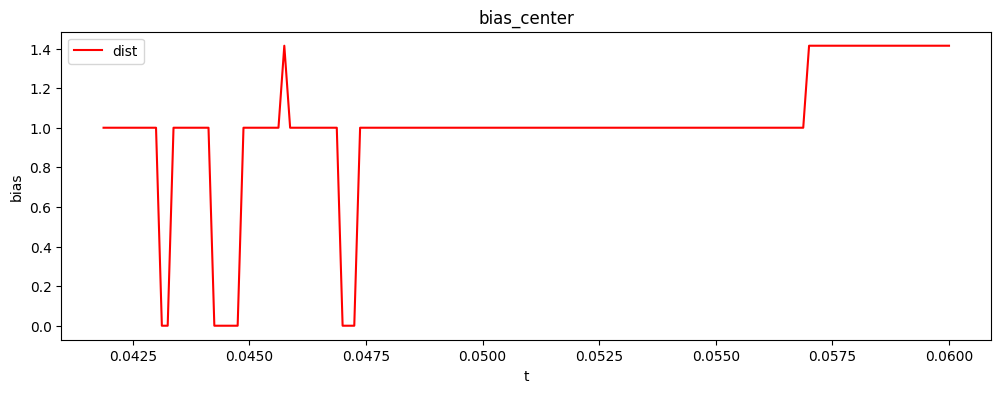

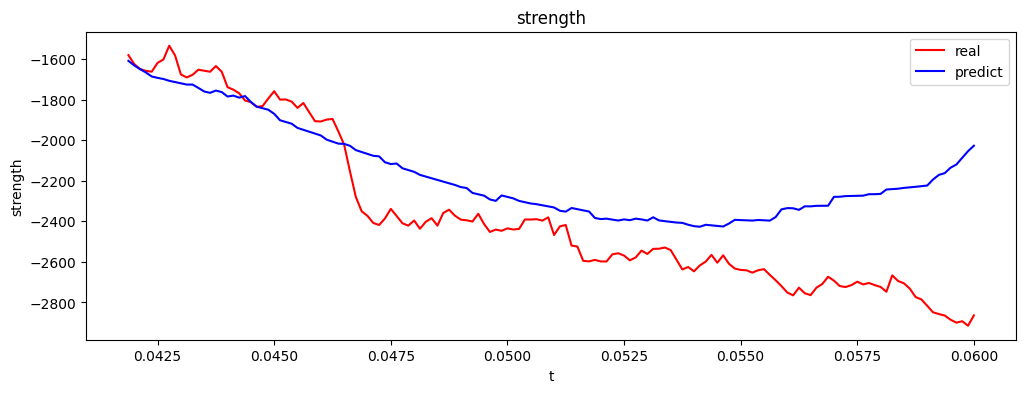

round: 8
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -489.514 1 + 248.832 Vx + 11.797 Vy + 19024.673 t + 66.224 VxVx + 22.787 VyVy + -178281.551 tt + -2.774 VxVy + -4094.165 Vxt + 254.893 Vyt + -0.920 VxVxVy + -1214.360 VxVxt + -381.665 VyVyt + -55.048 VxVyt + -3834.718 Vx_2 + -3913.826 Vy_2 + -2121.166 Vx_1 + -849.444 Vy_1 + -98.873 VxVx_2 + 115.029 VxVy_2 + 147246.950 Vxt_2 + -13.495 VyVx_2 + -73.590 VyVy_2 + -1390485.009 Vyt_2 + 11.694 tVx_2 + 1556.385 tVy_2 + -3087.686 tt_2 + 1.004 VxVxVx_2 + 183.817 VxVxVy_2 + 1253.196 VxVxt_2 + -28.030 VyVyVx_2 + -46.041 VyVyVy_2 + -36.942 VyVyt_2 + 149764.298 ttVx_2 + 28.335 ttVy_2 + 1.493 ttt_2 + -1416462.485 VxVyVx_2 + 76.908 VxVyVy_2 + 1701.257 VxVyt_2 + 665.939 VxtVx_2 + 0.776 VxtVy_2 + -661.032 Vxtt_2 + -33.892 VytVx_2 + -1225.333 VytVy_2 + -12.311 VxVx_1 + -42.817 VxVy_1 + 81892.983 Vxt_1 + 5.188 VyVx_1 + -23.438 VyVy_1 + -780856.260 Vyt_1 + -160.901 tVx_1 + 177.680 tVy_1 + -742.283 tt_1 + -0.595 VxVxVx_1 + -33.255 VxVxVy_1 + 683.451 VxVxt_1 + 3

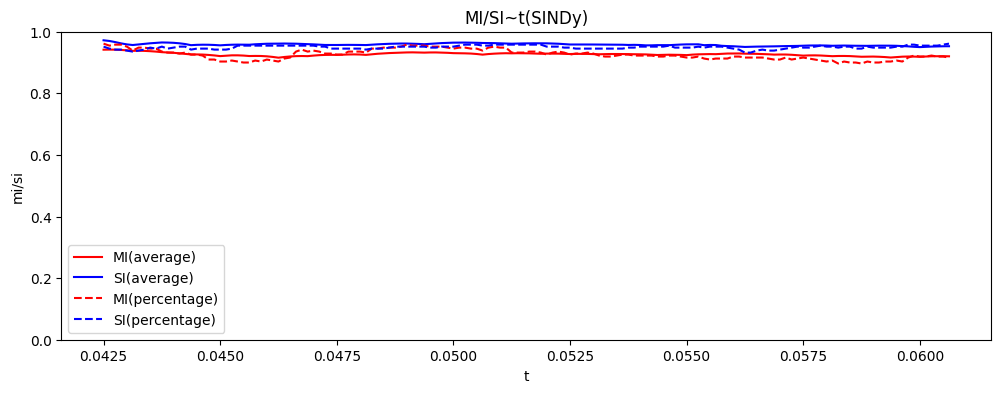

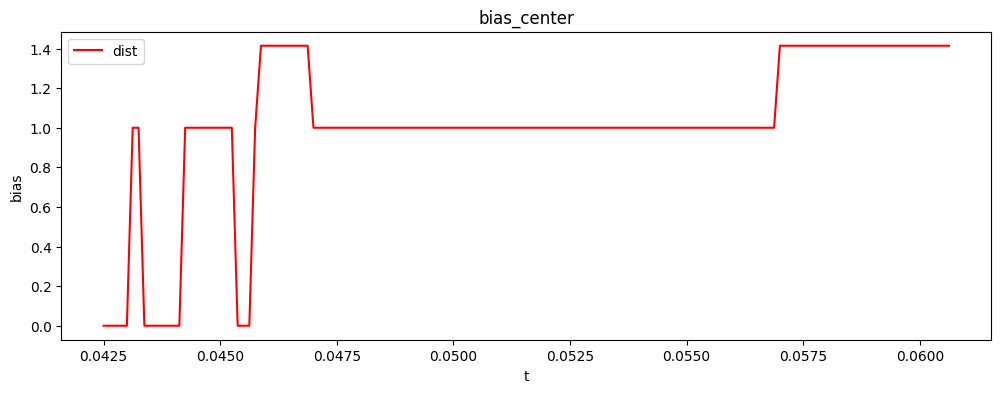

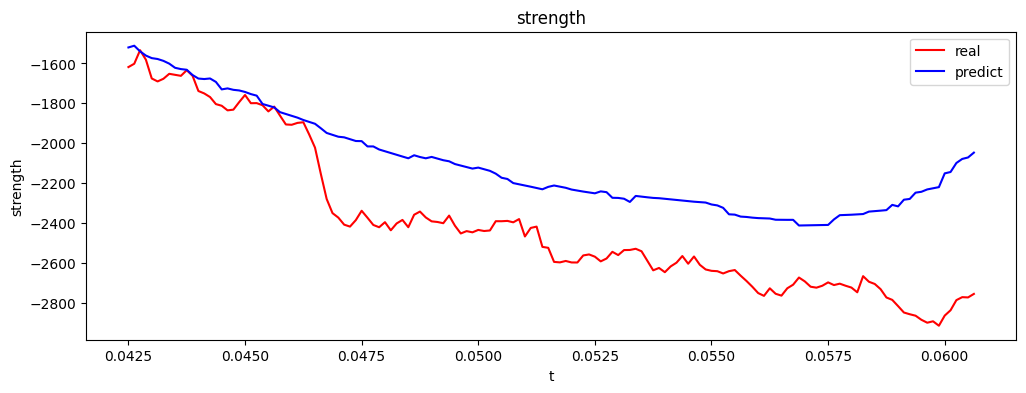

round: 9
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -634.032 1 + 209.192 Vx + -29.296 Vy + 23897.298 t + 71.417 VxVx + 31.469 VyVy + -218743.100 tt + -30.833 VxVy + -3290.053 Vxt + 1054.661 Vyt + -0.395 VxVxVy + -1330.313 VxVxt + -560.058 VyVyt + 482.493 VxVyt + -3136.158 Vx_2 + -2868.270 Vy_2 + -2983.993 Vx_1 + 95.186 Vy_1 + -95.545 VxVx_2 + 10.205 VxVy_2 + 117950.311 Vxt_2 + -5.069 VyVx_2 + -73.471 VyVy_2 + -1088723.782 Vyt_2 + 78.944 tVx_2 + 1771.373 tVy_2 + -1113.098 tt_2 + 66.066 VxVxVy_2 + 1283.138 VxVxt_2 + -1430.353 VyVyVx_2 + -62.052 VyVyVy_2 + 20.117 VyVyt_2 + 108922.494 ttVx_2 + -57.021 ttVy_2 + -5.964 ttt_2 + -1021419.108 VxVyVx_2 + 106.692 VxVyVy_2 + 2291.792 VxVyt_2 + -493.586 VxtVx_2 + 0.585 VxtVy_2 + 1006.139 Vxtt_2 + 123.227 VytVx_2 + -1864.688 VytVy_2 + -129.264 VxVx_1 + 125.063 VxVy_1 + 114682.966 Vxt_1 + -18.712 VyVx_1 + -64.035 VyVy_1 + -1089617.025 Vyt_1 + -121.611 tVx_1 + 2267.927 tVy_1 + -4083.966 tt_1 + -0.392 VxVxVx_1 + 371.998 VxVxVy_1 + 1491.162 VxVxt_1 + 2280.31

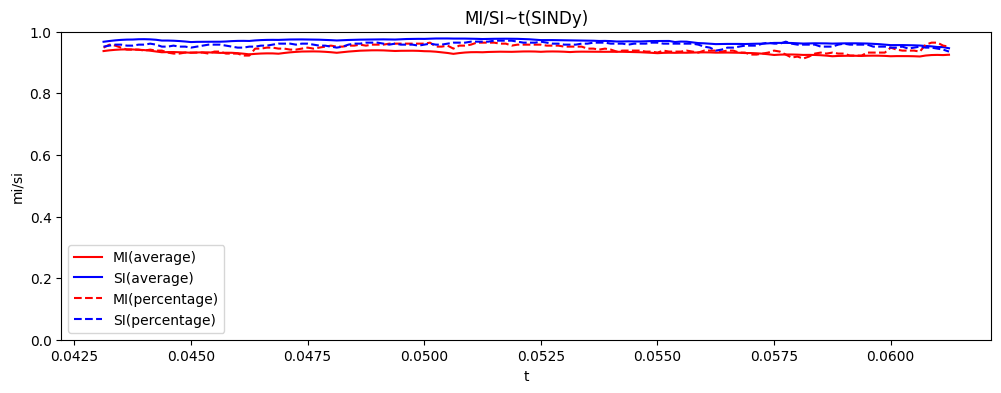

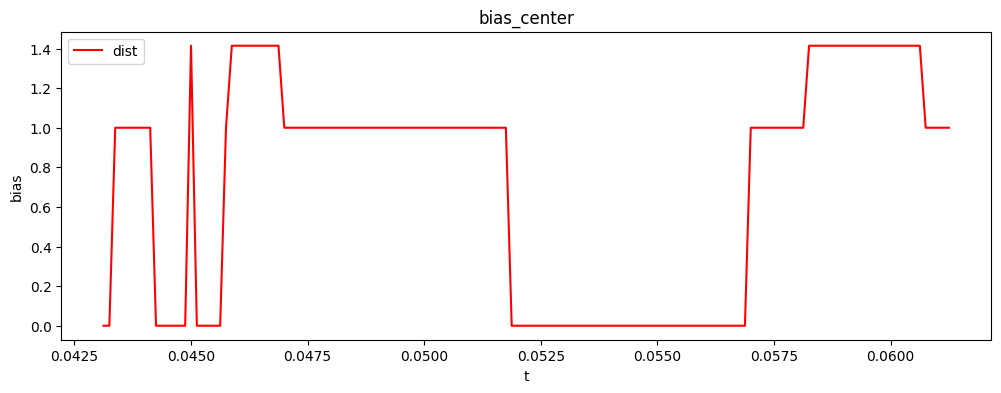

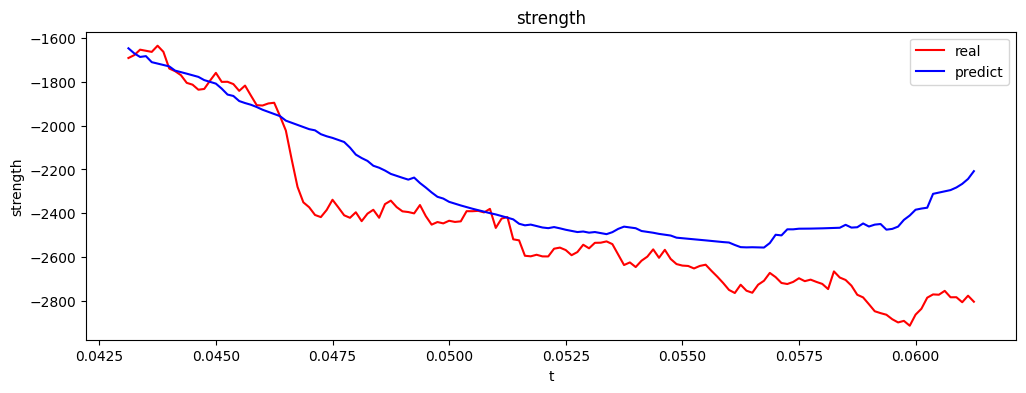

round: 10
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -691.701 1 + 267.420 Vx + 18.266 Vy + 27160.353 t + 76.381 VxVx + 27.256 VyVy + -259085.937 tt + -13.112 VxVy + -4272.472 Vxt + 192.759 Vyt + -0.786 VxVxVy + -1394.776 VxVxt + -501.746 VyVyt + 113.087 VxVyt + -4703.240 Vx_2 + -3485.416 Vy_2 + -4847.959 Vx_1 + -855.942 Vy_1 + 82.305 VxVx_2 + -81.879 VxVy_2 + 178574.331 Vxt_2 + 24.023 VyVx_2 + -74.459 VyVy_2 + -1670030.420 Vyt_2 + 9.453 tVx_2 + -1714.014 tVy_2 + 455.447 tt_2 + 0.989 VxVxVx_2 + -494.704 VxVxVy_2 + 1344.440 VxVxt_2 + -22.748 VyVyVx_2 + 40.463 VyVyVy_2 + -20.335 VyVyt_2 + 131698.098 ttVx_2 + -0.662 ttt_2 + -1230874.645 VxVyVx_2 + 89.618 VxVyVy_2 + 272.444 VxVyt_2 + 346.497 VxtVx_2 + 0.701 VxtVy_2 + -89.080 Vxtt_2 + 8.158 VytVx_2 + -1565.123 VytVy_2 + -44.385 VxVx_1 + -21.590 VxVy_1 + 184906.250 Vxt_1 + 8.563 VyVx_1 + 3.931 VyVy_1 + -1744623.679 Vyt_1 + -127.719 tVx_1 + 785.089 tVy_1 + -1298.642 tt_1 + -0.915 VxVxVx_1 + -98.615 VxVxVy_1 + 173.411 VxVxt_1 + 2373.000 VyVyVx_1 + 5

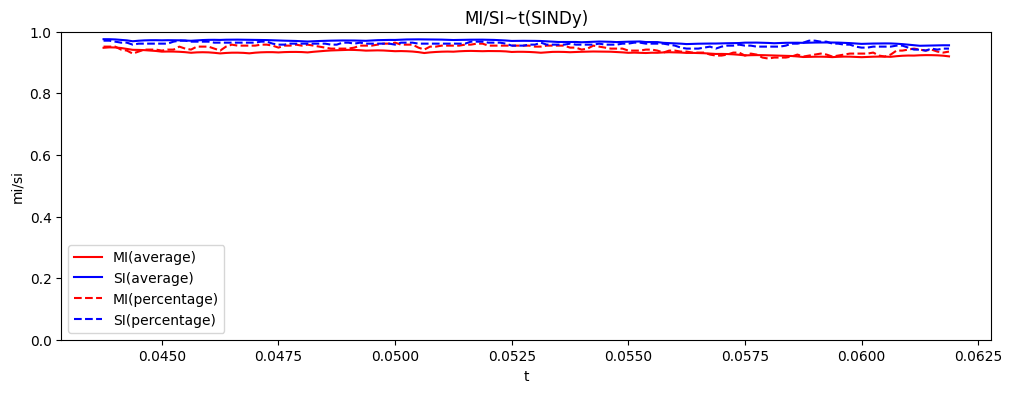

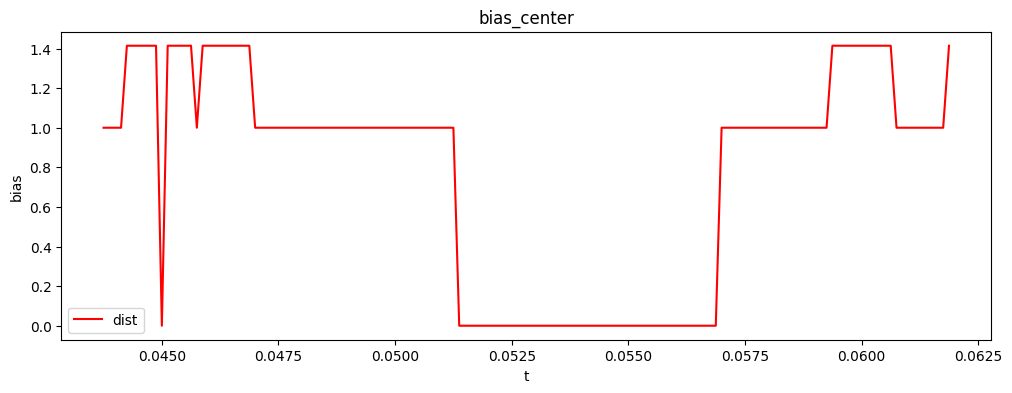

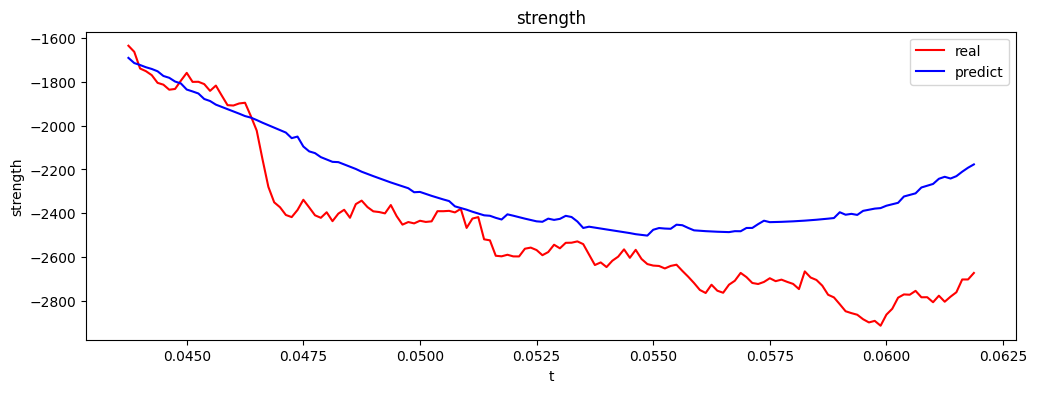

round: 11
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -436.993 1 + 227.488 Vx + -24.405 Vy + 16592.288 t + 79.501 VxVx + 11.985 VyVy + -150899.383 tt + -7.020 VxVy + -3648.132 Vxt + 868.847 Vyt + -0.555 VxVxVy + -1445.136 VxVxt + -205.911 VyVyt + 26.214 VxVyt + -3929.556 Vx_2 + -2212.755 Vy_2 + -3055.525 Vx_1 + 246.465 Vy_1 + 40.977 VxVx_2 + -105.956 VxVy_2 + 146941.163 Vxt_2 + 19.553 VyVx_2 + -29.904 VyVy_2 + -1350334.158 Vyt_2 + 1.754 tVx_2 + -1101.433 tVy_2 + 1030.858 tt_2 + 1.537 VxVxVx_2 + -427.497 VxVxVy_2 + 510.085 VxVxt_2 + 131.861 VyVyVx_2 + 160.113 VyVyVy_2 + 19.765 VyVyt_2 + 82708.554 ttVx_2 + -1.271 ttVy_2 + -2.962 ttt_2 + -762996.326 VxVyVx_2 + 16.548 VxVyVy_2 + -2230.943 VxVyt_2 + -391.260 VxtVx_2 + 20.393 Vxtt_2 + 40.972 VytVx_2 + -205.291 VytVy_2 + -22.732 VxVx_1 + -75.619 VxVy_1 + 115030.943 Vxt_1 + 0.533 VyVx_1 + -15.240 VyVy_1 + -1071426.140 Vyt_1 + -128.116 tVx_1 + 361.163 tVy_1 + 32.406 tt_1 + -1.499 VxVxVx_1 + 106.274 VxVxVy_1 + 521.879 VxVxt_1 + 2300.137 VyVyVx_1 + -16

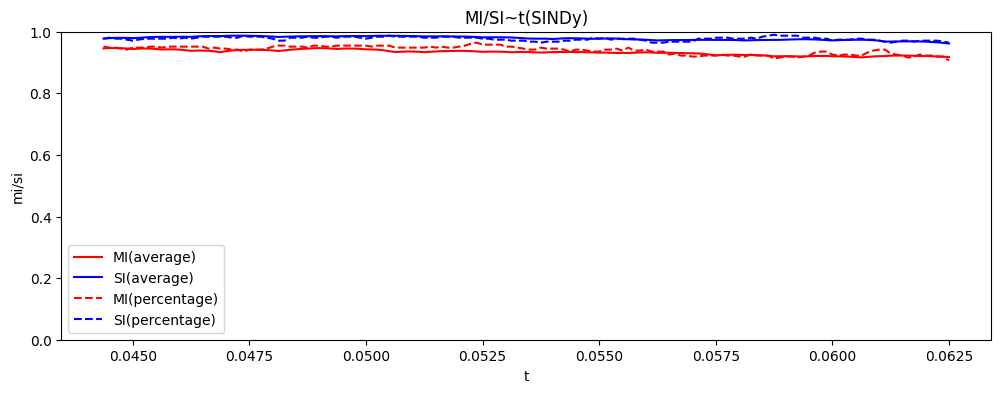

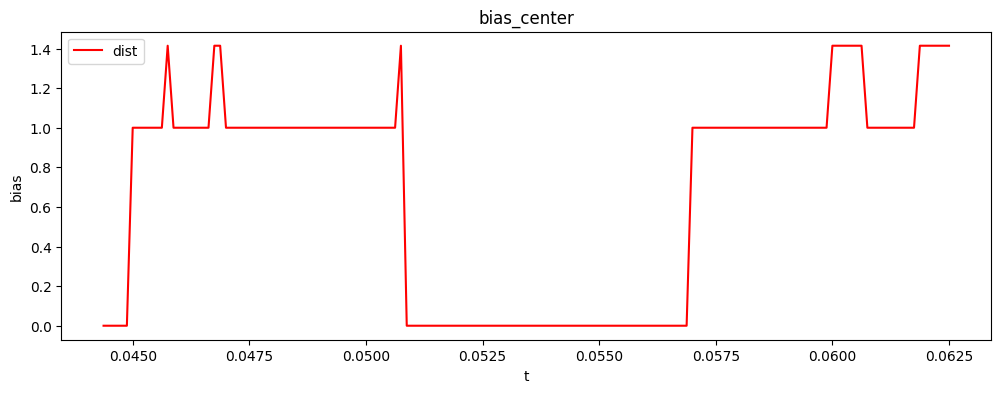

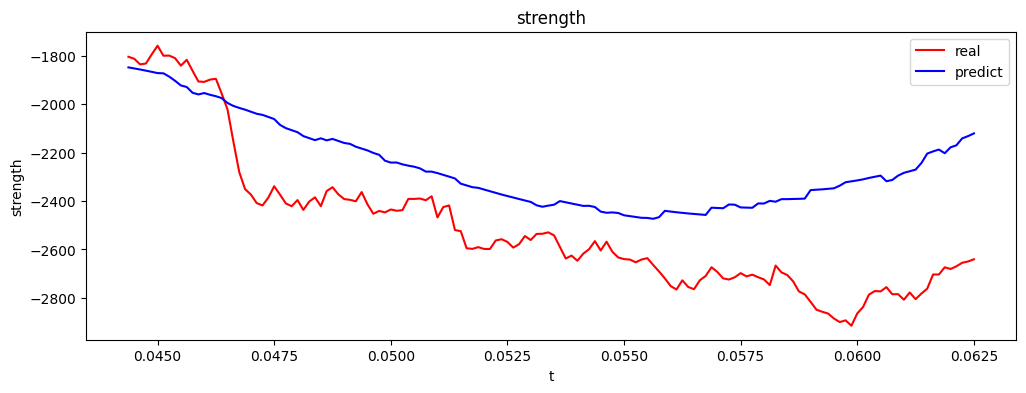

round: 12
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 326.766 1 + 213.318 Vx + 42.490 Vy + -11445.445 t + 69.176 VxVx + 9.077 VyVy + 104500.018 tt + -48.140 VxVy + -3391.924 Vxt + -304.617 Vyt + -0.695 VxVxVy + -1243.484 VxVxt + -134.852 VyVyt + 790.316 VxVyt + -3581.653 Vx_2 + -4580.495 Vy_2 + -6118.859 Vx_1 + -1009.280 Vy_1 + 9.426 VxVx_2 + -125.256 VxVy_2 + 132206.830 Vxt_2 + 6.988 VyVx_2 + -23.091 VyVy_2 + -1197135.971 Vyt_2 + 66.403 tVx_2 + -542.828 tVy_2 + 1224.638 tt_2 + 1.233 VxVxVx_2 + -202.227 VxVxVy_2 + 357.732 VxVxt_2 + -1046.075 VyVyVx_2 + 156.237 VyVyVy_2 + -10.564 VyVyt_2 + 169265.310 ttVx_2 + -58.574 ttVy_2 + 3.638 ttt_2 + -1546905.715 VxVyVx_2 + 29.928 VxVyVy_2 + -1949.465 VxVyt_2 + 169.118 VxtVx_2 + 0.533 VxtVy_2 + 1020.395 Vxtt_2 + -81.332 VytVx_2 + -402.531 VytVy_2 + -93.175 VxVx_1 + -261.150 VxVy_1 + 226874.086 Vxt_1 + -6.357 VyVx_1 + 40.663 VyVy_1 + -2083242.344 Vyt_1 + -183.221 tVx_1 + 1644.422 tVy_1 + 3471.125 tt_1 + -0.428 VxVxVx_1 + 182.965 VxVxVy_1 + -556.844 VxVxt

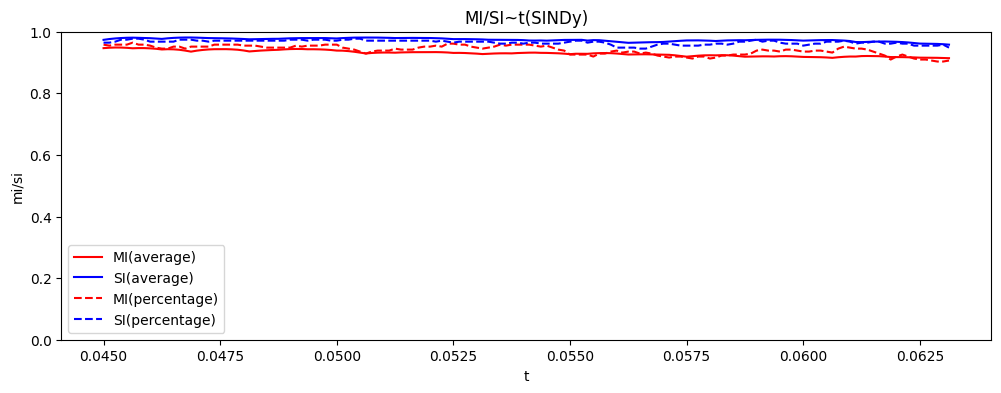

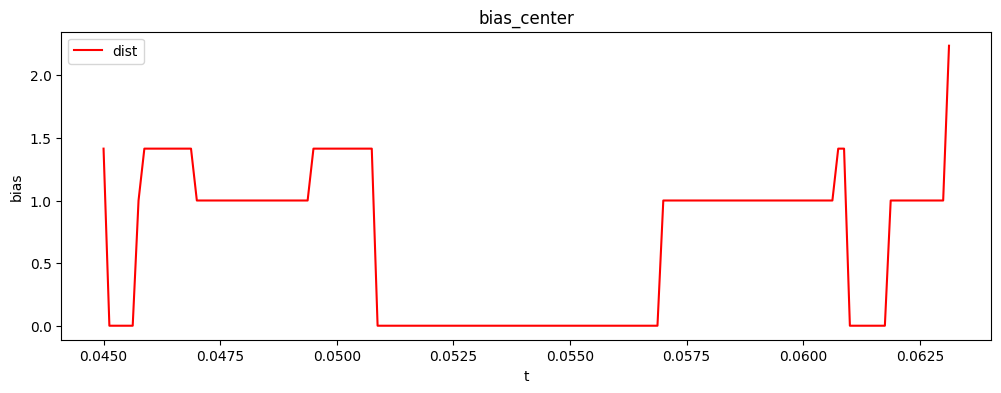

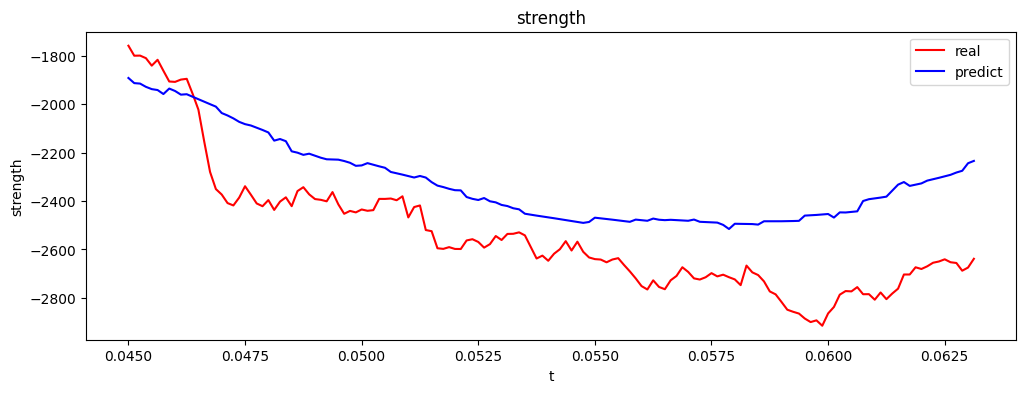

round: 13
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -42.328 1 + 236.856 Vx + -44.834 Vy + 2286.483 t + 48.764 VxVx + 7.566 VyVy + -22361.912 tt + -51.060 VxVy + -3851.429 Vxt + 1195.625 Vyt + -0.722 VxVxVy + -848.601 VxVxt + -99.405 VyVyt + 825.123 VxVyt + -3613.562 Vx_2 + -1570.191 Vy_2 + -3901.114 Vx_1 + -260.492 Vy_1 + 79.094 VxVx_2 + 78.733 VxVy_2 + 134529.798 Vxt_2 + 18.844 VyVx_2 + -55.079 VyVy_2 + -1229145.132 Vyt_2 + 54.409 tVx_2 + -1777.759 tVy_2 + -2485.989 tt_2 + 0.955 VxVxVx_2 + -405.229 VxVxVy_2 + 945.153 VxVxt_2 + -764.125 VyVyVx_2 + -218.163 VyVyVy_2 + -20.798 VyVyt_2 + 57053.113 ttVx_2 + -59.992 ttVy_2 + 4.244 ttt_2 + -511961.035 VxVyVx_2 + 80.225 VxVyVy_2 + 4938.377 VxVyt_2 + 422.061 VxtVx_2 + -0.581 VxtVy_2 + 1015.173 Vxtt_2 + -88.365 VytVx_2 + -1348.007 VytVy_2 + -199.463 VxVx_1 + -250.125 VxVy_1 + 142664.124 Vxt_1 + -23.036 VyVx_1 + 70.449 VyVy_1 + -1292314.922 Vyt_1 + -76.127 tVx_1 + 3662.395 tVy_1 + 3333.713 tt_1 + -0.947 VxVxVx_1 + 520.621 VxVxVy_1 + -1158.284 VxVxt_

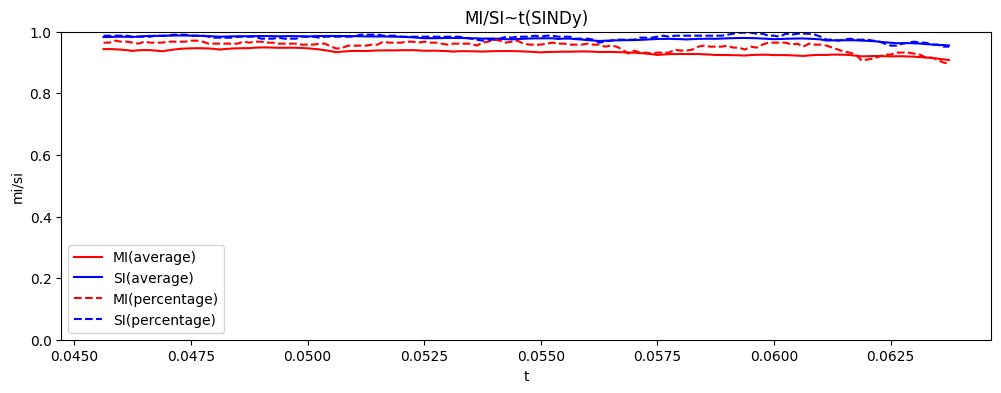

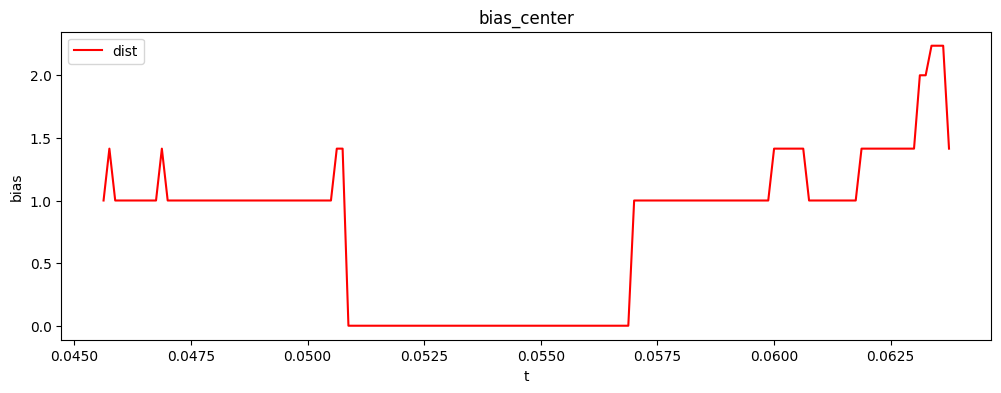

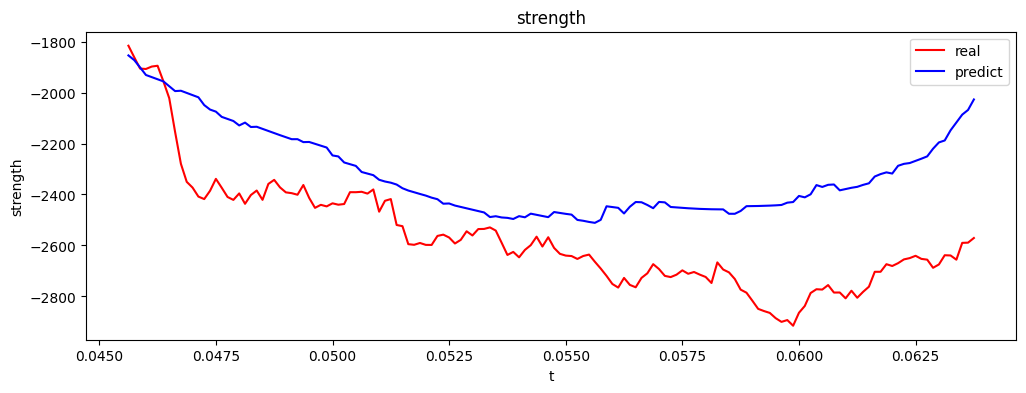

round: 14
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 465.707 1 + 137.043 Vx + 19.073 Vy + -16000.054 t + 21.820 VxVx + -10.646 VyVy + 141289.115 tt + -77.743 VxVy + -2121.959 Vxt + 135.988 Vyt + -0.926 VxVxVy + -354.690 VxVxt + 193.661 VyVyt + 1322.470 VxVyt + -3031.336 Vx_2 + -394.794 Vy_2 + -3308.768 Vx_1 + -1100.570 Vy_1 + 157.427 VxVx_2 + 3.659 VxVy_2 + 110345.394 Vxt_2 + 29.043 VyVx_2 + -18.135 VyVy_2 + -983944.810 Vyt_2 + 67.059 tVx_2 + -3330.897 tVy_2 + -1351.507 tt_2 + 1.409 VxVxVx_2 + -607.945 VxVxVy_2 + 366.985 VxVxt_2 + -1006.251 VyVyVx_2 + -146.889 VyVyVy_2 + -61.134 VyVyt_2 + 12539.924 ttVx_2 + -82.813 ttVy_2 + 10.029 ttt_2 + -94926.489 VxVyVx_2 + 44.102 VxVyVy_2 + 3918.454 VxVyt_2 + 1143.187 VxtVx_2 + -0.436 VxtVy_2 + 1483.859 Vxtt_2 + -192.671 VytVx_2 + -804.132 VytVy_2 + -76.138 VxVx_1 + -321.164 VxVy_1 + 119155.114 Vxt_1 + 128.331 VyVy_1 + -1061581.430 Vyt_1 + -35.295 tVx_1 + 1303.745 tVy_1 + 4708.052 tt_1 + -0.459 VxVxVx_1 + 69.837 VxVxVy_1 + -2184.814 VxVxt_1 + 576.848 Vy

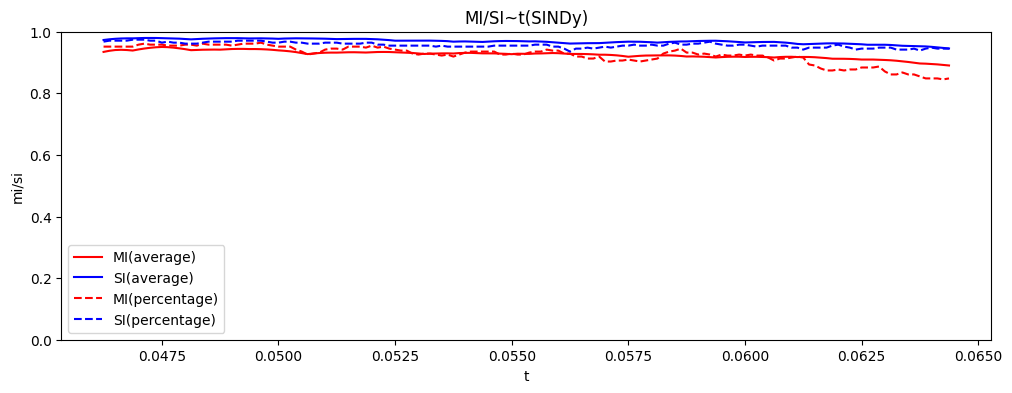

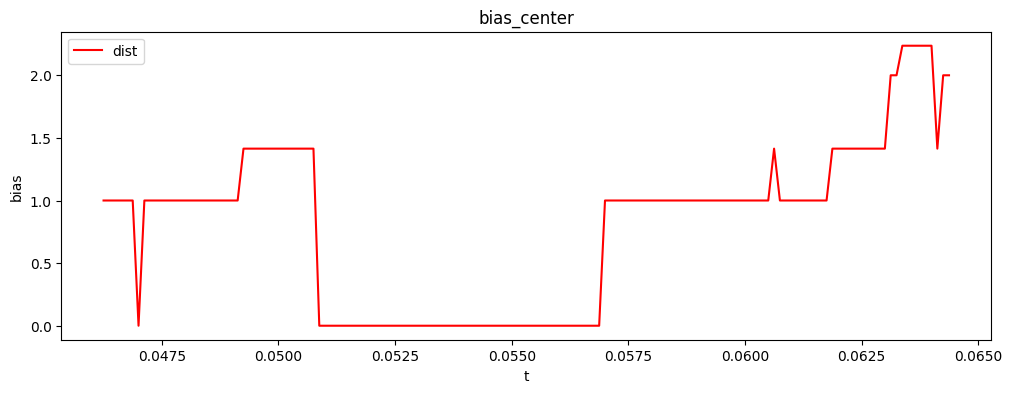

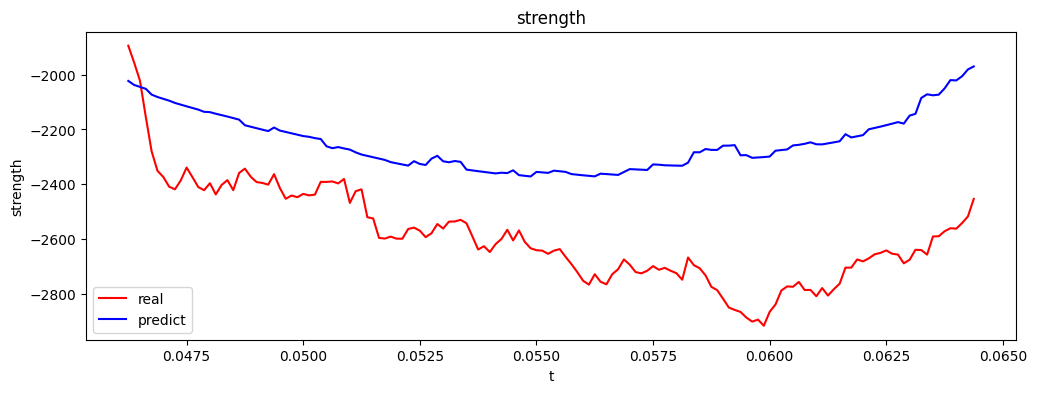

round: 15
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 731.373 1 + 150.412 Vx + -67.014 Vy + -25249.859 t + 20.931 VxVx + 6.606 VyVy + 220439.654 tt + -60.837 VxVy + -2284.265 Vxt + 1696.404 Vyt + -0.566 VxVxVy + -327.435 VxVxt + -109.719 VyVyt + 997.729 VxVyt + -3428.799 Vx_2 + -1680.843 Vy_2 + -4093.246 Vx_1 + -900.545 Vy_1 + 45.060 VxVx_2 + 192.761 VxVy_2 + 124524.998 Vxt_2 + 9.034 VyVx_2 + -69.505 VyVy_2 + -1109323.122 Vyt_2 + 52.914 tVx_2 + -1152.231 tVy_2 + -4882.479 tt_2 + 0.323 VxVxVx_2 + -228.214 VxVxVy_2 + 1288.426 VxVxt_2 + -750.314 VyVyVx_2 + -256.746 VyVyVy_2 + -63.755 VyVyt_2 + 61803.636 ttVx_2 + -52.215 ttVy_2 + 4.250 ttt_2 + -559271.087 VxVyVx_2 + 86.195 VxVyVy_2 + 6027.002 VxVyt_2 + 1198.964 VxtVx_2 + -0.124 VxtVy_2 + 799.501 Vxtt_2 + -92.299 VytVx_2 + -1541.801 VytVy_2 + -68.963 VxVx_1 + -219.598 VxVy_1 + 148423.361 Vxt_1 + -7.351 VyVx_1 + 69.400 VyVy_1 + -1330785.615 Vyt_1 + -35.972 tVx_1 + 1235.267 tVy_1 + 2771.067 tt_1 + -0.601 VxVxVx_1 + 187.561 VxVxVy_1 + -1150.724 VxVx

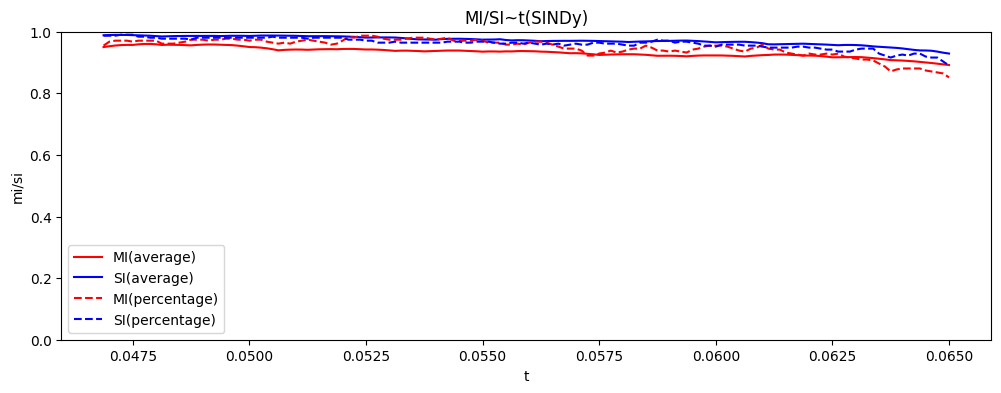

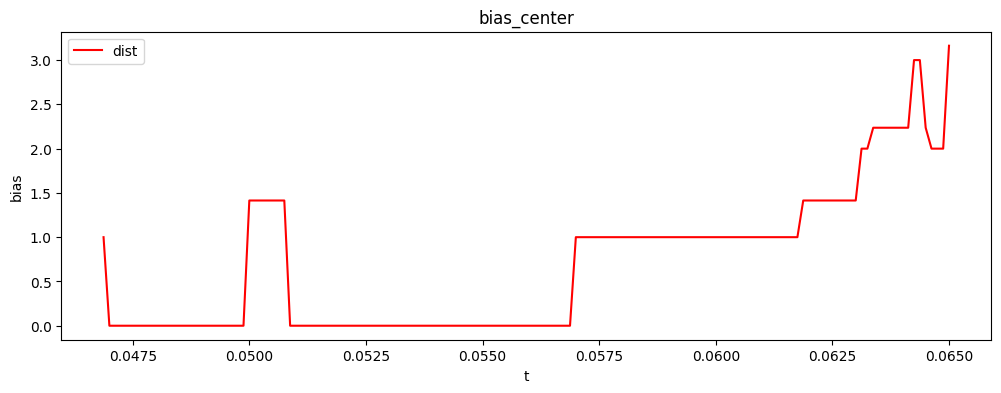

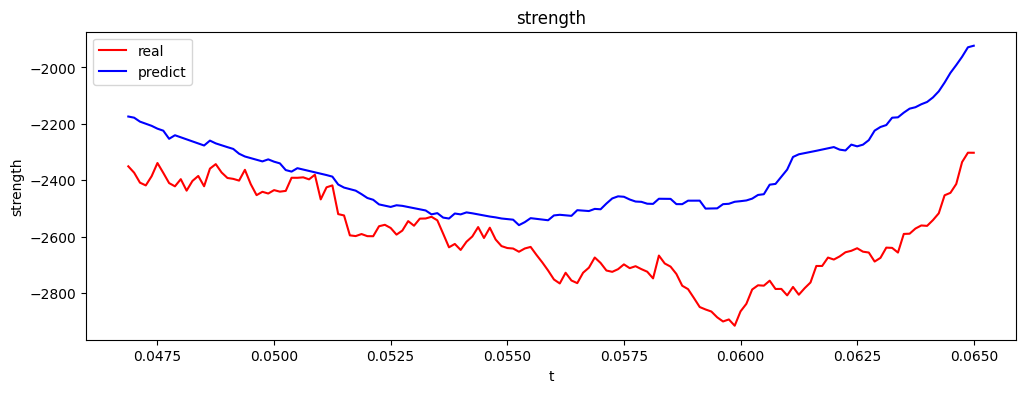

round: 16
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 959.225 1 + 111.520 Vx + -52.010 Vy + -33275.945 t + -14.229 VxVx + 14.763 VyVy + 290505.219 tt + -49.228 VxVy + -1640.714 Vxt + 1409.941 Vyt + -0.916 VxVxVy + 312.781 VxVxt + -232.552 VyVyt + 768.195 VxVyt + -2694.412 Vx_2 + -858.364 Vy_2 + -4320.725 Vx_1 + -1092.125 Vy_1 + 89.834 VxVx_2 + 326.025 VxVy_2 + 98143.172 Vxt_2 + 20.592 VyVx_2 + -93.754 VyVy_2 + -874760.232 Vyt_2 + 19.909 tVx_2 + -1820.433 tVy_2 + -7111.592 tt_2 + 0.125 VxVxVx_2 + -401.404 VxVxVy_2 + 1663.872 VxVxt_2 + -186.093 VyVyVx_2 + -365.998 VyVyVy_2 + -6.243 VyVyt_2 + 32295.928 ttVx_2 + -41.626 ttVy_2 + -3.440 ttt_2 + -296855.472 VxVyVx_2 + 90.410 VxVyVy_2 + 7679.929 VxVyt_2 + 109.877 VxtVx_2 + 600.779 Vxtt_2 + 53.586 VytVx_2 + -1535.378 VytVy_2 + -59.801 VxVx_1 + -281.533 VxVy_1 + 155105.636 Vxt_1 + -7.907 VyVx_1 + 85.570 VyVy_1 + -1377088.883 Vyt_1 + -10.047 tVx_1 + 842.589 tVy_1 + 3865.806 tt_1 + 0.425 VxVxVx_1 + 135.978 VxVxVy_1 + -1412.588 VxVxt_1 + 92.450 VyVyVx_1

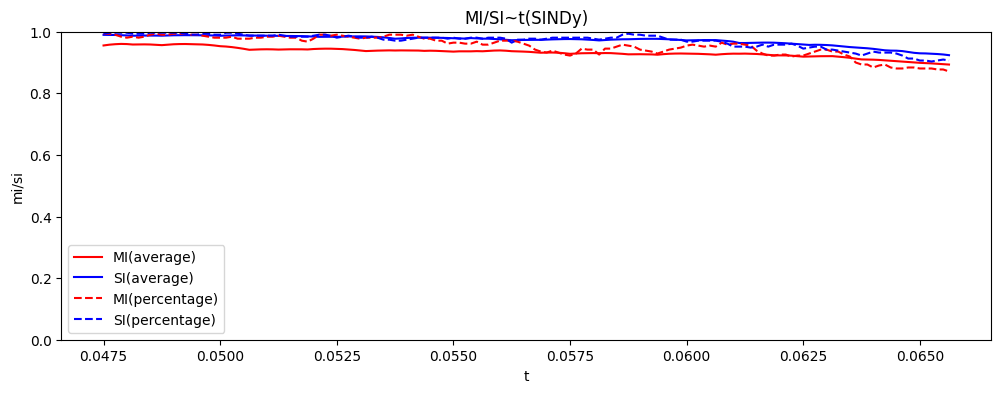

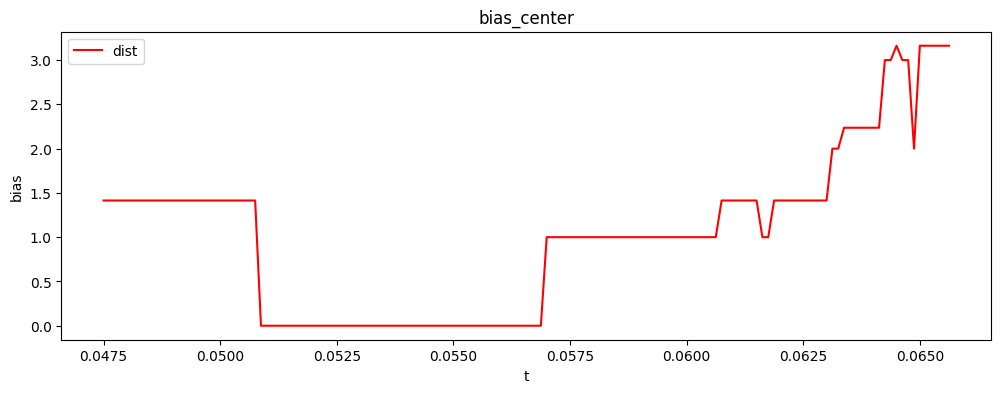

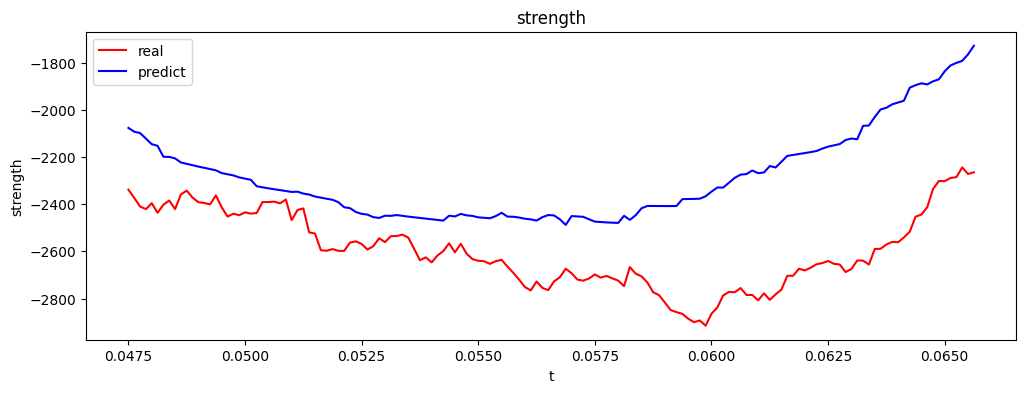

round: 17
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 1119.422 1 + 3.330 Vx + -76.564 Vy + -38327.985 t + -0.518 VxVx + 10.929 VyVy + 329744.827 tt + -45.408 VxVy + 286.864 Vxt + 1792.642 Vyt + -1.123 VxVxVy + 74.187 VxVxt + -147.916 VyVyt + 667.892 VxVyt + -2079.294 Vx_2 + 73.261 Vy_2 + -3894.492 Vx_1 + -1597.881 Vy_1 + -38.563 VxVx_2 + 165.076 VxVy_2 + 74383.932 Vxt_2 + -4.335 VyVx_2 + -58.934 VyVy_2 + -649147.897 Vyt_2 + 85.198 tVx_2 + 387.569 tVy_2 + -4123.152 tt_2 + 0.051 VxVxVx_2 + 35.297 VxVxVy_2 + 1010.407 VxVxt_2 + -1281.025 VyVyVx_2 + -122.954 VyVyVy_2 + -36.496 VyVyt_2 + -2623.433 ttVx_2 + -92.418 ttVy_2 + 2.371 ttt_2 + 26525.423 VxVyVx_2 + 59.078 VxVyVy_2 + 3279.382 VxVyt_2 + 627.113 VxtVx_2 + -0.341 VxtVy_2 + 1479.412 Vxtt_2 + -49.425 VytVx_2 + -939.848 VytVy_2 + 17.329 VxVx_1 + 61.345 VxVy_1 + 136843.777 Vxt_1 + 14.822 VyVx_1 + -3.446 VyVy_1 + -1189905.824 Vyt_1 + -33.131 tVx_1 + -454.373 tVy_1 + -2289.655 tt_1 + 0.012 VxVxVx_1 + -231.819 VxVxVy_1 + 197.183 VxVxt_1 + 499.856 Vy

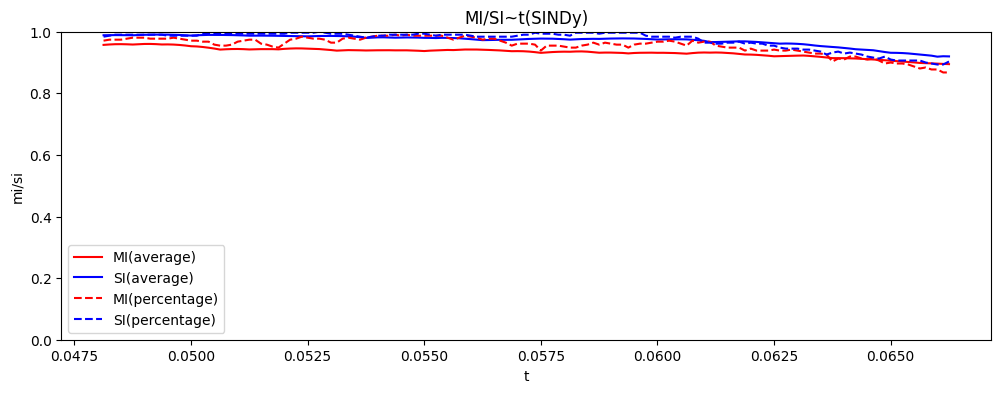

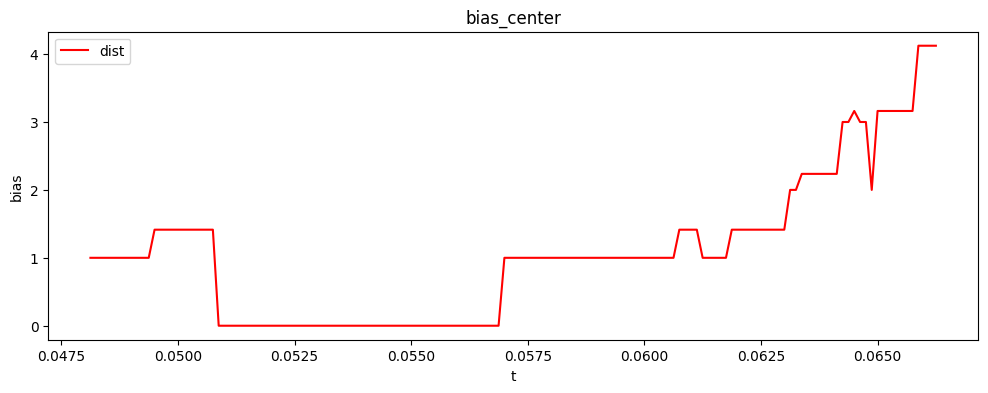

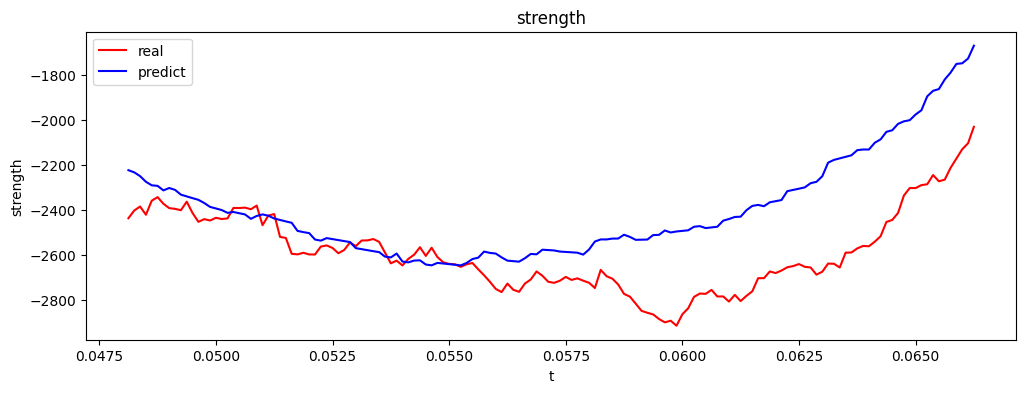

round: 18
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 1519.225 1 + -142.389 Vx + 71.474 Vy + -51634.194 t + -52.905 VxVx + 3.914 VyVy + 439210.408 tt + -10.137 VxVy + 2887.371 Vxt + -880.812 Vyt + -0.826 VxVxVy + 981.195 VxVxt + -8.208 VyVyt + 19.196 VxVyt + -731.481 Vx_2 + -84.446 Vy_2 + -3437.398 Vx_1 + -347.999 Vy_1 + 63.041 VxVx_2 + -82.415 VxVy_2 + 28372.321 Vxt_2 + 15.654 VyVx_2 + -41.416 VyVy_2 + -258693.211 Vyt_2 + 15.561 tVx_2 + -1435.223 tVy_2 + 459.349 tt_2 + 0.137 VxVxVx_2 + -327.626 VxVxVy_2 + 656.364 VxVxt_2 + -1.184 VyVyVx_2 + 187.329 VyVyVy_2 + -0.196 VyVyt_2 + 3326.429 ttVx_2 + -14.087 ttVy_2 + -5.151 ttt_2 + -29395.628 VxVyVx_2 + 22.162 VxVyVy_2 + -2531.725 VxVyt_2 + 13.293 VxtVx_2 + 2.144 Vxtt_2 + 83.758 VytVx_2 + -218.329 VytVy_2 + 72.121 VxVx_1 + 126.883 VxVy_1 + 118672.235 Vxt_1 + 10.517 VyVx_1 + -18.752 VyVy_1 + -1014191.287 Vyt_1 + 7.801 tVx_1 + -1296.780 tVy_1 + -3631.965 tt_1 + -0.626 VxVxVx_1 + -111.426 VxVxVy_1 + 511.533 VxVxt_1 + -214.912 VyVyVx_1 + -196.991 VyVy

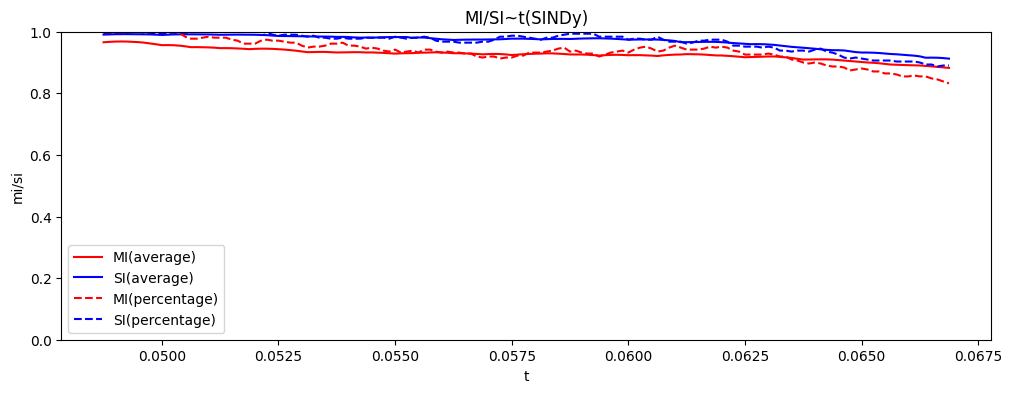

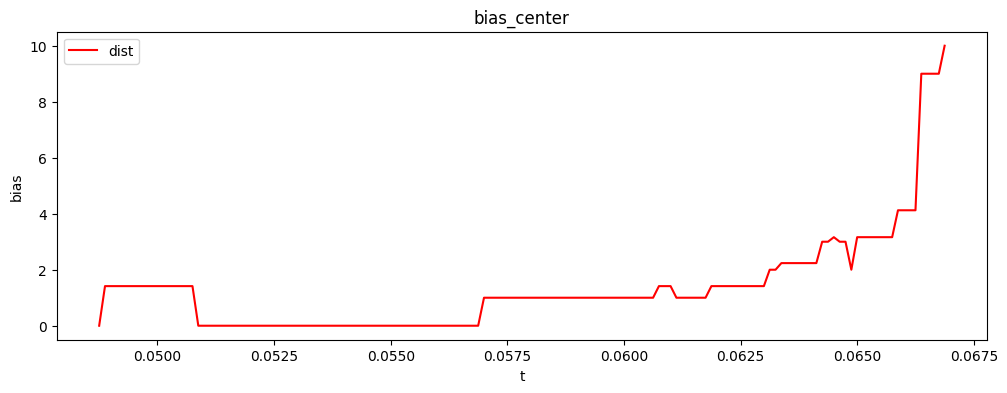

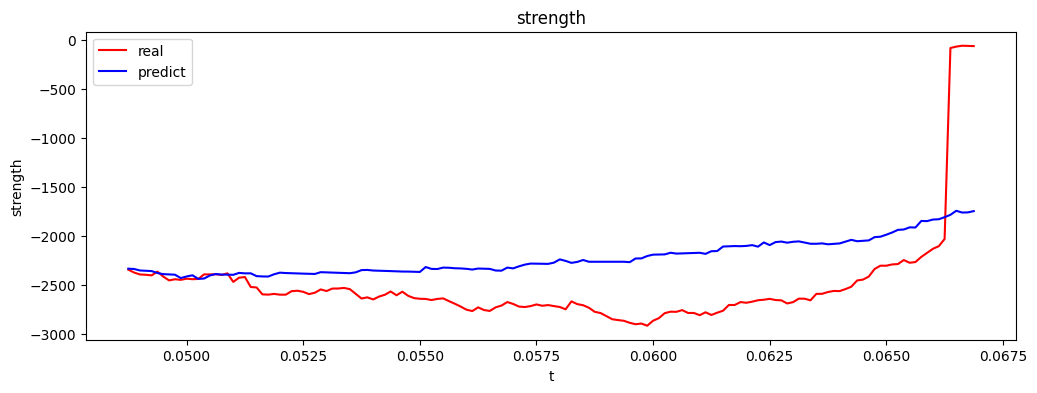

round: 19
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 1494.963 1 + -78.034 Vx + 8.539 Vy + -49864.744 t + -60.045 VxVx + 15.917 VyVy + 416476.839 tt + -43.159 VxVy + 1776.090 Vxt + 189.214 Vyt + -0.905 VxVxVy + 1108.888 VxVxt + -221.669 VyVyt + 618.508 VxVyt + -2506.538 Vx_2 + -290.500 Vy_2 + -4144.173 Vx_1 + -1341.985 Vy_1 + -135.223 VxVx_2 + 80.153 VxVy_2 + 89373.914 Vxt_2 + -21.519 VyVx_2 + -82.621 VyVy_2 + -780088.395 Vyt_2 + 15.157 tVx_2 + 1914.420 tVy_2 + -2418.952 tt_2 + 0.433 VxVxVx_2 + 304.492 VxVxVy_2 + 1397.673 VxVxt_2 + -30.735 VyVyVx_2 + 128.596 VyVyVy_2 + 11.180 VyVyt_2 + 9959.954 ttVx_2 + 16.581 ttVy_2 + -5.804 ttt_2 + -82194.743 VxVyVx_2 + 64.961 VxVyVy_2 + -1448.959 VxVyt_2 + -204.534 VxtVx_2 + -0.162 VxtVy_2 + -420.746 Vxtt_2 + 92.702 VytVx_2 + -988.725 VytVy_2 + 25.980 VxVx_1 + -18.477 VxVy_1 + 142392.561 Vxt_1 + 25.087 VyVx_1 + 27.192 VyVy_1 + -1211532.308 Vyt_1 + 12.510 tVx_1 + -371.466 tVy_1 + -1131.581 tt_1 + -0.640 VxVxVx_1 + -333.488 VxVxVy_1 + -323.474 VxVxt_1 + -35

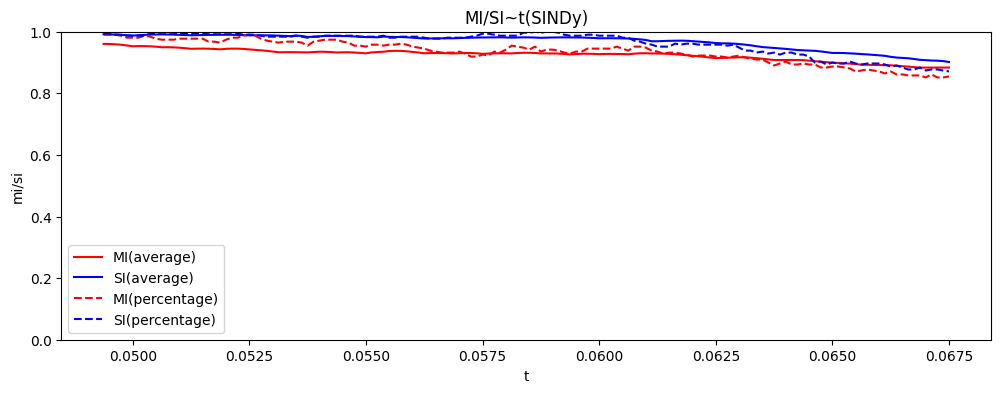

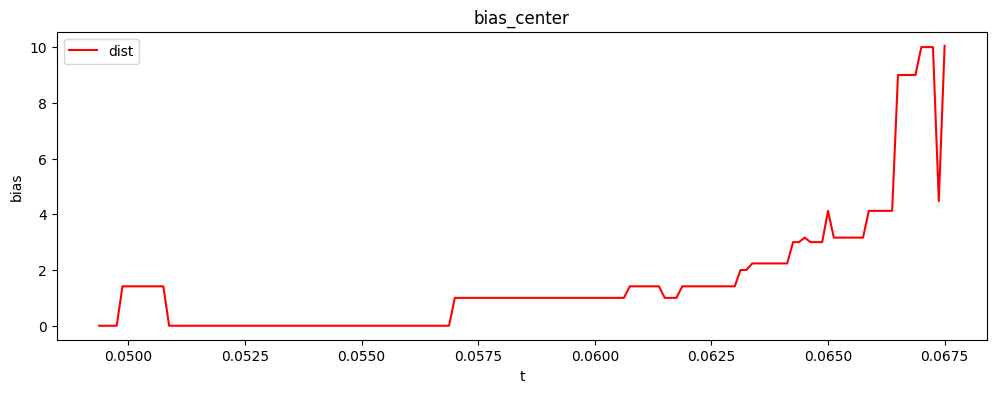

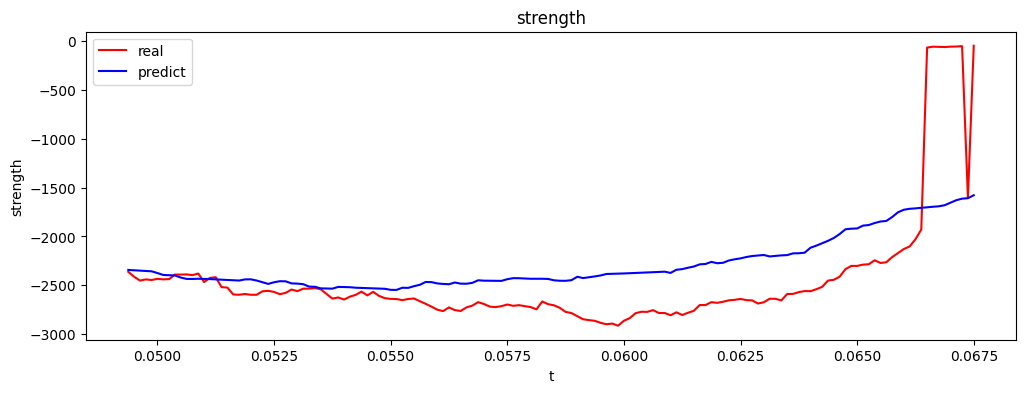

round: 20
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 670.147 1 + -28.880 Vx + 12.346 Vy + -21443.917 t + -48.580 VxVx + -23.546 VyVy + 173585.795 tt + 16.330 VxVy + 834.392 Vxt + 220.283 Vyt + -0.973 VxVxVy + 879.987 VxVxt + 480.714 VyVyt + -408.412 VxVyt + -143.205 Vx_2 + 2010.580 Vy_2 + -1999.091 Vx_1 + -163.764 Vy_1 + -198.485 VxVx_2 + 102.725 VxVy_2 + 8331.629 Vxt_2 + -28.375 VyVx_2 + -2.435 VyVy_2 + -91097.694 Vyt_2 + -12.539 tVx_2 + 3069.965 tVy_2 + -3015.062 tt_2 + 0.379 VxVxVx_2 + 430.457 VxVxVy_2 + -23.341 VxVxt_2 + 428.397 VyVyVx_2 + 142.593 VyVyVy_2 + 47.938 VyVyt_2 + -68259.790 ttVx_2 + 57.371 ttVy_2 + -5.025 ttt_2 + 577617.186 VxVyVx_2 + -23.404 VxVyVy_2 + -1390.566 VxVyt_2 + -806.027 VxtVx_2 + -0.274 VxtVy_2 + -1101.632 Vxtt_2 + 77.273 VytVx_2 + 566.060 VytVy_2 + 121.137 VxVx_1 + -106.044 VxVy_1 + 69624.050 Vxt_1 + 45.381 VyVx_1 + -36.494 VyVy_1 + -598661.068 Vyt_1 + -6.576 tVx_1 + -2094.668 tVy_1 + 139.837 tt_1 + -705.645 VxVxVy_1 + 766.534 VxVxt_1 + -36.293 VyVyVx_1 + 5.674 

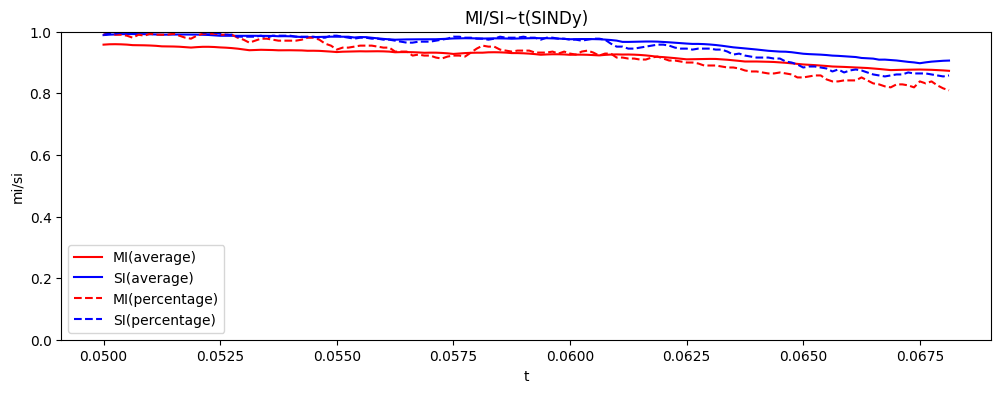

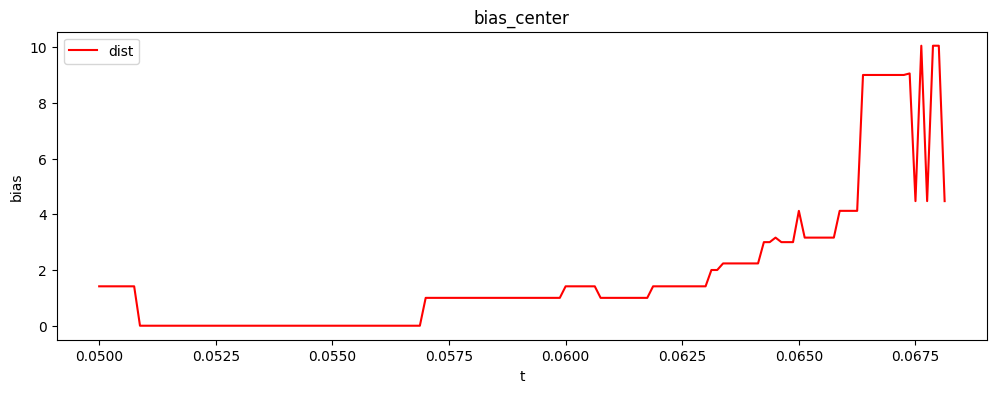

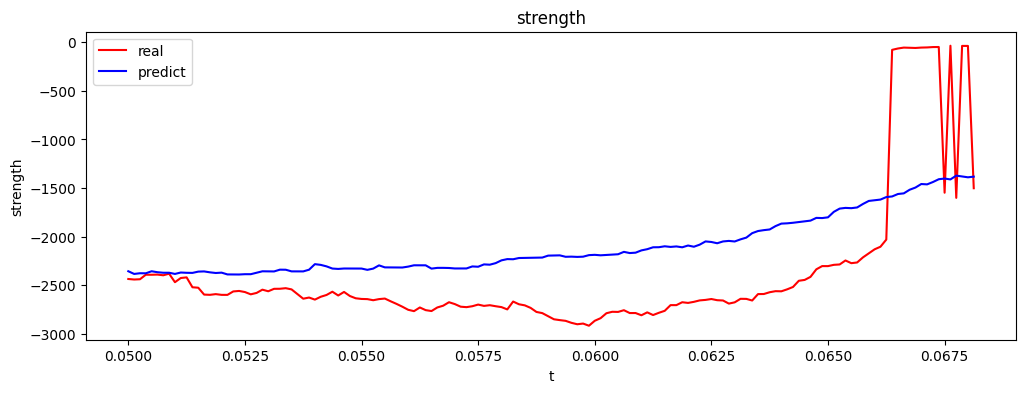

round: 21
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 1258.275 1 + -26.300 Vx + 58.881 Vy + -41481.432 t + -38.890 VxVx + -35.586 VyVy + 343652.953 tt + 8.236 VxVy + 796.103 Vxt + -468.893 Vyt + -1.264 VxVxVy + 703.605 VxVxt + 660.786 VyVyt + -270.441 VxVyt + 1573.364 Vx_2 + 2919.625 Vy_2 + 725.946 Vx_1 + -675.383 Vy_1 + -81.107 VxVx_2 + 219.032 VxVy_2 + -50008.836 Vxt_2 + -10.914 VyVy_2 + 401632.030 Vyt_2 + 24.173 tVx_2 + 1117.961 tVy_2 + -5134.027 tt_2 + 1.026 VxVxVx_2 + -40.823 VxVxVy_2 + 159.567 VxVxt_2 + -210.296 VyVyVx_2 + 23.536 VyVyVy_2 + -6.533 VyVyt_2 + -98362.290 ttVx_2 + 47.426 ttVy_2 + -1.889 ttt_2 + 824736.093 VxVyVx_2 + -6.474 VxVyVy_2 + 679.568 VxVyt_2 + 71.132 VxtVx_2 + -0.304 VxtVy_2 + -843.802 Vxtt_2 + 28.620 VytVx_2 + 252.983 VytVy_2 + 118.097 VxVx_1 + -342.194 VxVy_1 + -22444.177 Vxt_1 + 54.335 VyVx_1 + 9.222 VyVy_1 + 172902.479 Vyt_1 + -98.894 tVx_1 + -2031.527 tVy_1 + 3889.823 tt_1 + -836.654 VxVxVy_1 + 102.763 VxVxt_1 + 1570.202 VyVyVx_1 + 220.885 VyVyVy_1 + -103.788 

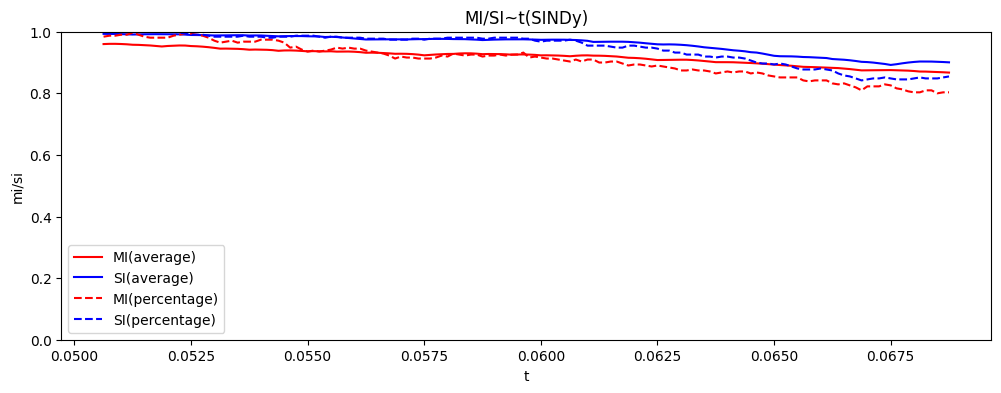

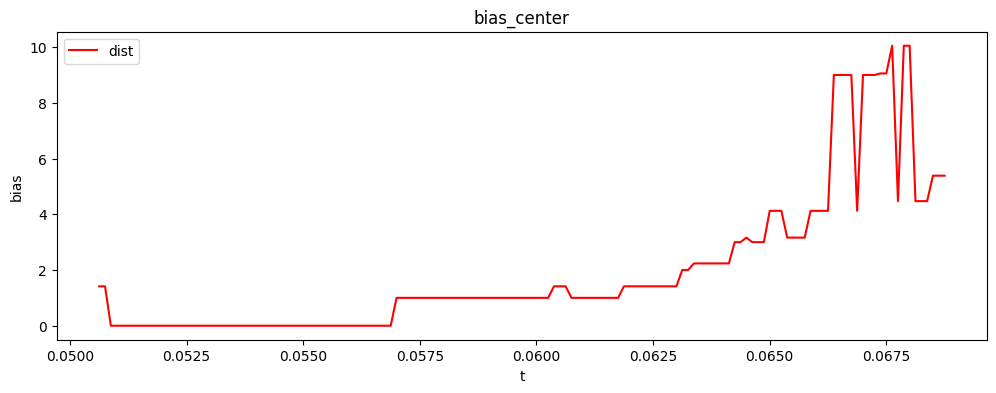

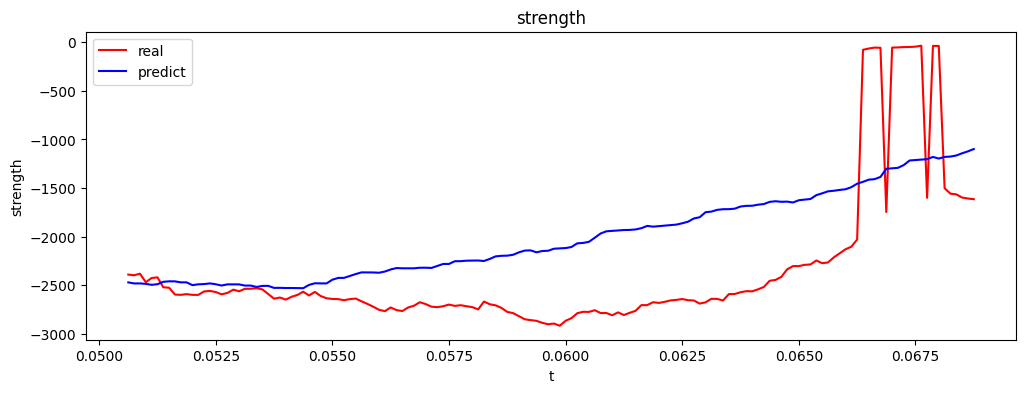

round: 22
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 2824.473 1 + 21.818 Vx + 58.786 Vy + -93622.514 t + -34.784 VxVx + -31.151 VyVy + 774534.574 tt + -15.712 VxVy + 35.342 Vxt + -445.065 Vyt + -1.222 VxVxVy + 625.448 VxVxt + 605.953 VyVyt + 119.878 VxVyt + 3240.600 Vx_2 + 250.758 Vy_2 + -3279.007 Vx_1 + 872.443 Vy_1 + -81.852 VxVx_2 + 226.909 VxVy_2 + -104214.097 Vxt_2 + 5.993 VyVx_2 + -19.059 VyVy_2 + 839964.720 Vyt_2 + 16.894 tVx_2 + 1088.016 tVy_2 + -5251.340 tt_2 + 1.093 VxVxVx_2 + -157.543 VxVxVy_2 + 270.779 VxVxt_2 + -49.924 VyVyVx_2 + -145.318 VyVyVy_2 + -44.331 VyVyt_2 + -6507.288 ttVx_2 + 32.883 ttVy_2 + -4.036 ttt_2 + 41487.174 VxVyVx_2 + -5.813 VxVyVy_2 + 3524.134 VxVyt_2 + 760.475 VxtVx_2 + -0.696 VxtVy_2 + -634.532 Vxtt_2 + 53.312 VytVx_2 + 253.615 VytVy_2 + 87.818 VxVx_1 + -293.167 VxVy_1 + 112795.438 Vxt_1 + 56.601 VyVx_1 + 105.436 VyVy_1 + -960936.370 Vyt_1 + -33.341 tVx_1 + -1531.226 tVy_1 + 3095.918 tt_1 + 0.320 VxVxVx_1 + -883.548 VxVxVy_1 + -1534.963 VxVxt_1 + 539.305 V

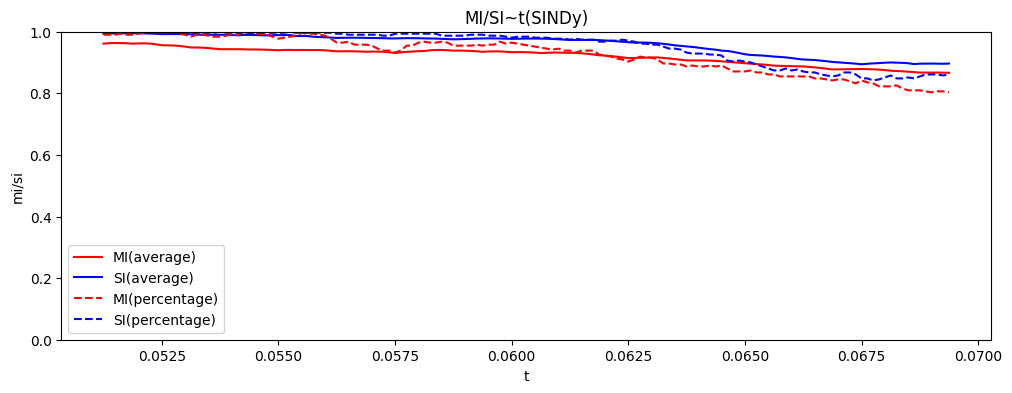

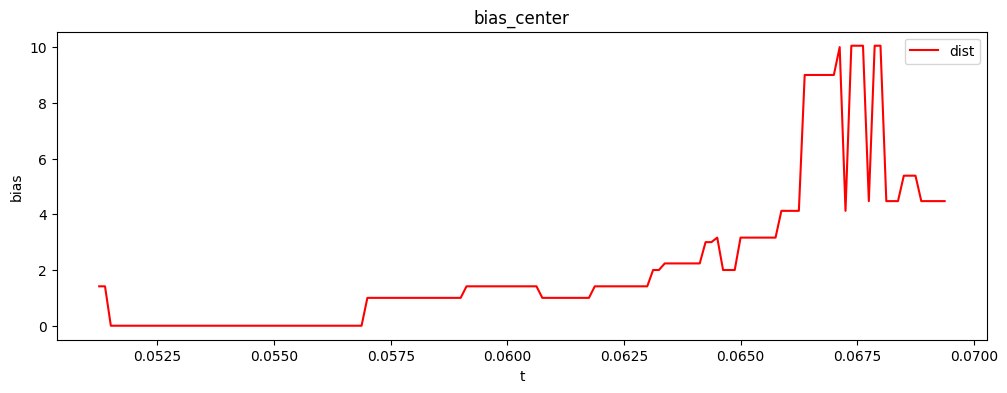

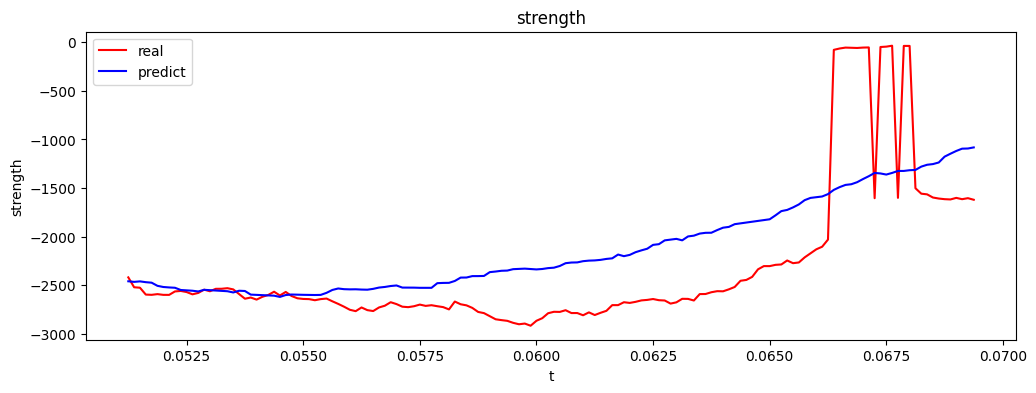

round: 23
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 3153.137 1 + 79.665 Vx + 12.015 Vy + -103802.452 t + -42.764 VxVx + -43.017 VyVy + 853118.815 tt + -30.222 VxVy + -902.159 Vxt + 279.927 Vyt + -1.431 VxVxVy + 752.979 VxVxt + 795.414 VyVyt + 344.278 VxVyt + 4506.315 Vx_2 + -170.425 Vy_2 + -1870.981 Vx_1 + -549.365 Vy_1 + -187.093 VxVx_2 + 487.034 VxVy_2 + -145252.722 Vxt_2 + -15.495 VyVx_2 + -12.507 VyVy_2 + 1171098.144 Vyt_2 + 62.330 tVx_2 + 2675.456 tVy_2 + -9300.965 tt_2 + 1.624 VxVxVx_2 + 169.027 VxVxVy_2 + 138.117 VxVxt_2 + -792.984 VyVyVx_2 + -310.850 VyVyVy_2 + -47.586 VyVyt_2 + 8605.838 ttVx_2 + 10.557 ttVy_2 + -2.418 ttt_2 + -91612.324 VxVyVx_2 + -2.154 VxVyVy_2 + 5945.237 VxVyt_2 + 737.660 VxtVx_2 + 0.149 VxtVy_2 + -269.769 Vxtt_2 + 30.279 VytVx_2 + 239.375 VytVy_2 + 118.845 VxVx_1 + -545.650 VxVy_1 + 66889.635 Vxt_1 + 71.471 VyVx_1 + 132.939 VyVy_1 + -588234.837 Vyt_1 + -50.691 tVx_1 + -1985.297 tVy_1 + 7044.433 tt_1 + 0.496 VxVxVx_1 + -1118.052 VxVxVy_1 + -1879.461 VxVxt_1 + 8

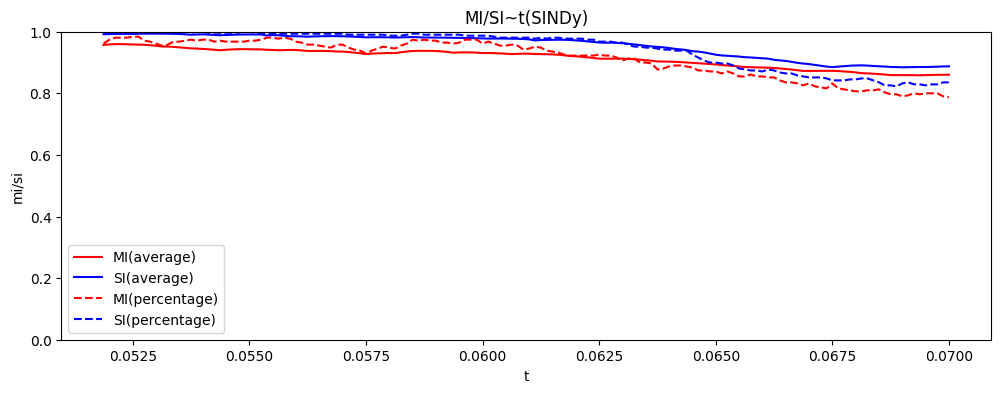

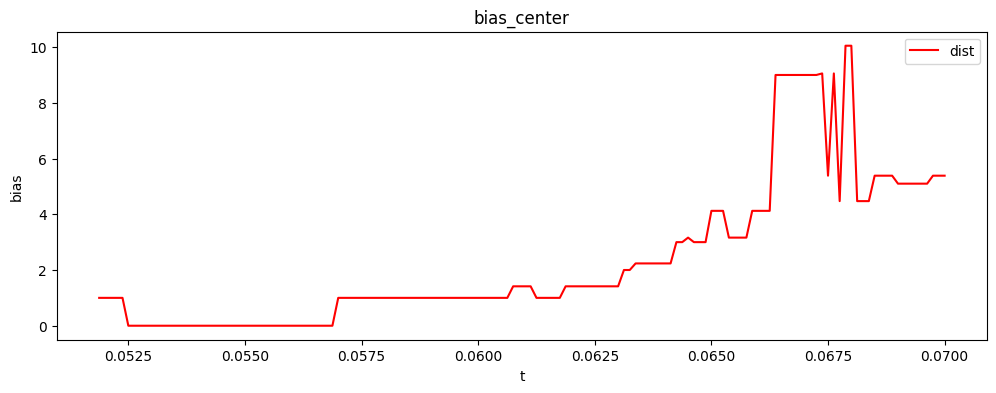

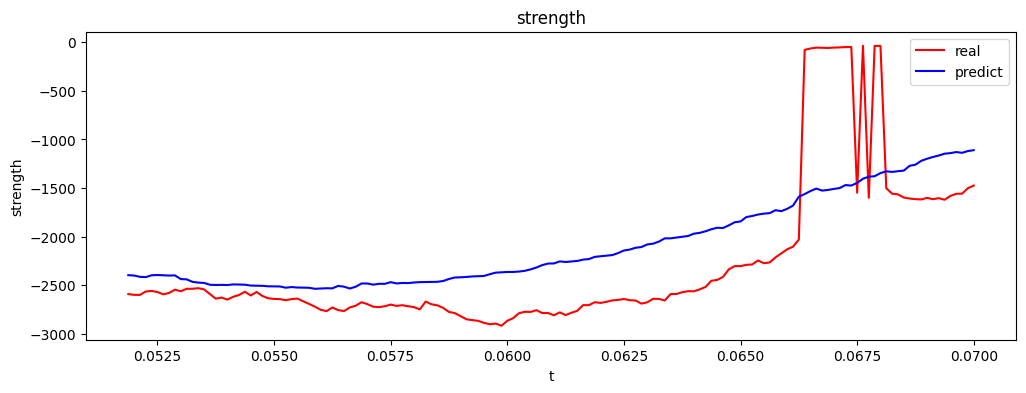

round: 24
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 3059.628 1 + 70.689 Vx + 46.459 Vy + -100275.976 t + -60.055 VxVx + -59.055 VyVy + 821245.579 tt + -28.341 VxVy + -858.826 Vxt + -217.977 Vyt + -1.049 VxVxVy + 969.077 VxVxt + 1058.839 VyVyt + 361.282 VxVyt + 4178.613 Vx_2 + -1244.806 Vy_2 + -2269.070 Vx_1 + -1424.020 Vy_1 + -71.196 VxVx_2 + 226.434 VxVy_2 + -134431.657 Vxt_2 + 10.106 VyVx_2 + -7.461 VyVy_2 + 1083816.159 Vyt_2 + -28.724 tVx_2 + 893.428 tVy_2 + -5206.179 tt_2 + 1.705 VxVxVx_2 + -243.839 VxVxVy_2 + 51.380 VxVxt_2 + 628.470 VyVyVx_2 + -269.263 VyVyVy_2 + -167.069 VyVyt_2 + 39926.538 ttVx_2 + 75.507 ttVy_2 + 12.497 ttt_2 + -314441.139 VxVyVx_2 + -12.961 VxVyVy_2 + 5484.904 VxVyt_2 + 2651.058 VxtVx_2 + -0.625 VxtVy_2 + -1245.241 Vxtt_2 + -199.327 VytVx_2 + 391.460 VytVy_2 + -65.084 VxVx_1 + -470.559 VxVy_1 + 76810.020 Vxt_1 + 39.644 VyVx_1 + 135.347 VyVy_1 + -643628.249 Vyt_1 + 13.577 tVx_1 + 753.743 tVy_1 + 5992.600 tt_1 + 0.419 VxVxVx_1 + -656.041 VxVxVy_1 + -1938.866 VxVxt_

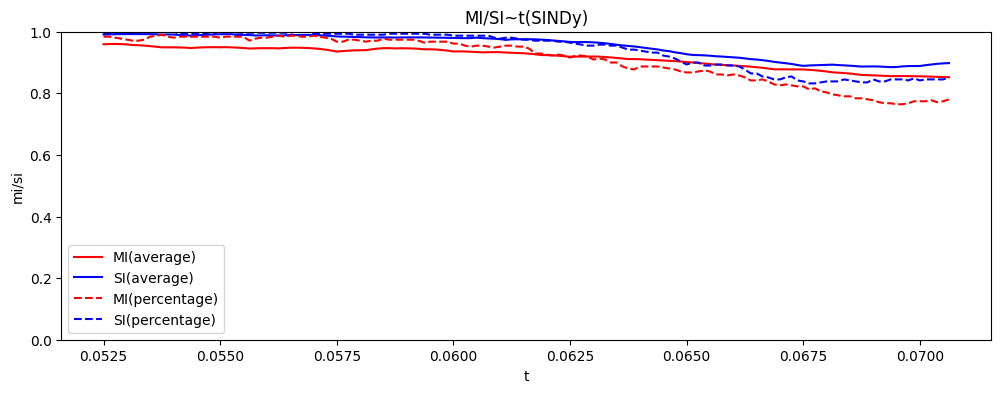

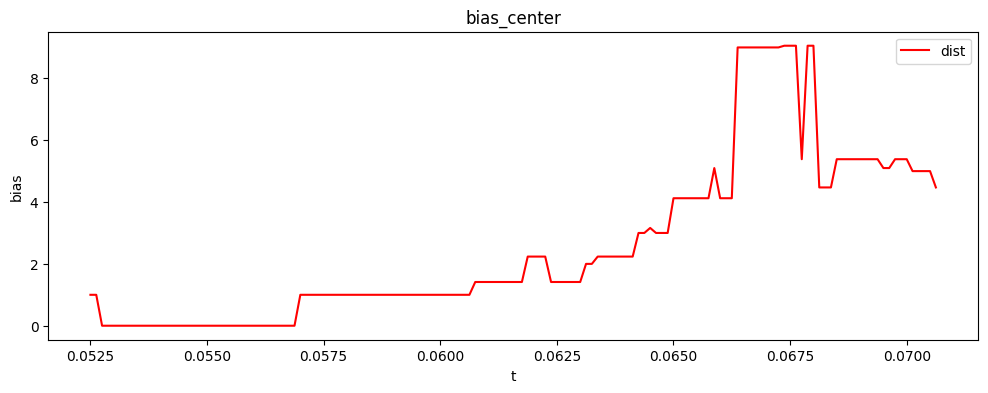

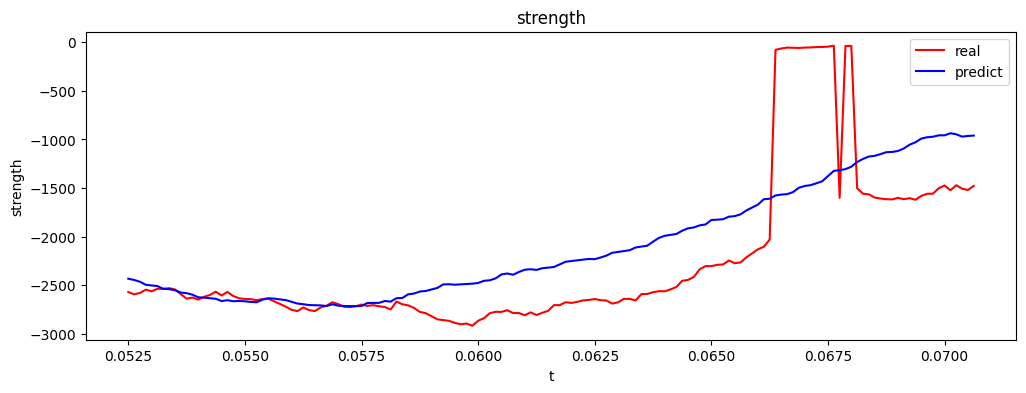

round: 25
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 3133.350 1 + 92.413 Vx + -22.953 Vy + -103006.191 t + -37.614 VxVx + -56.794 VyVy + 846217.396 tt + -41.956 VxVy + -1252.769 Vxt + 833.430 Vyt + -0.765 VxVxVy + 612.138 VxVxt + 1025.477 VyVyt + 592.262 VxVyt + 4649.130 Vx_2 + -512.828 Vy_2 + 375.832 Vx_1 + -1467.640 Vy_1 + -13.023 VxVx_2 + 389.582 VxVy_2 + -149029.695 Vxt_2 + 26.700 VyVx_2 + 2.285 VyVy_2 + 1196707.941 Vyt_2 + 5.125 tVx_2 + -41.891 tVy_2 + -7713.199 tt_2 + 1.279 VxVxVx_2 + -512.200 VxVxVy_2 + -115.097 VxVxt_2 + 88.761 VyVyVx_2 + -517.238 VyVyVy_2 + -90.260 VyVyt_2 + 19422.874 ttVx_2 + 27.110 ttVy_2 + -6.662 ttt_2 + -174164.201 VxVyVx_2 + -27.527 VxVyVy_2 + 9399.204 VxVyt_2 + 1404.289 VxtVx_2 + -0.509 VxtVy_2 + -498.182 Vxtt_2 + 108.216 VytVx_2 + 650.516 VytVy_2 + -72.312 VxVx_1 + -258.999 VxVy_1 + -5765.050 Vxt_1 + 50.543 VyVx_1 + 98.085 VyVy_1 + -3052.897 Vyt_1 + -4.887 tVx_1 + 888.832 tVy_1 + 2569.242 tt_1 + 1.688 VxVxVx_1 + -843.861 VxVxVy_1 + -1367.884 VxVxt_1 + 270.23

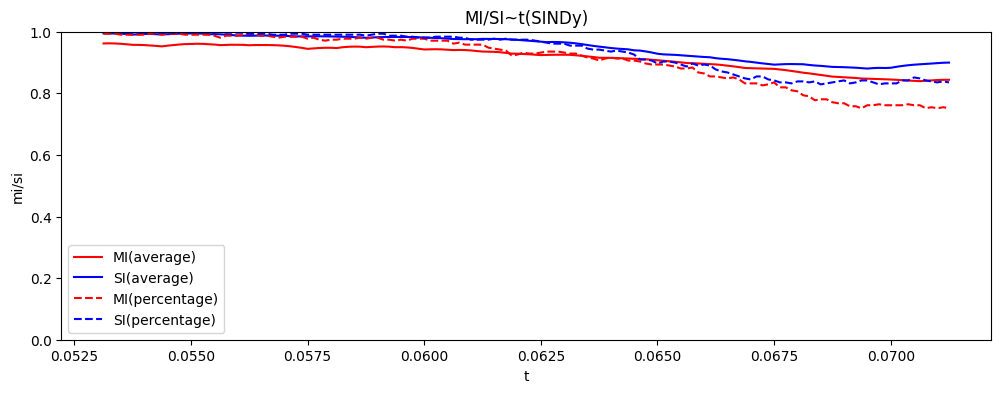

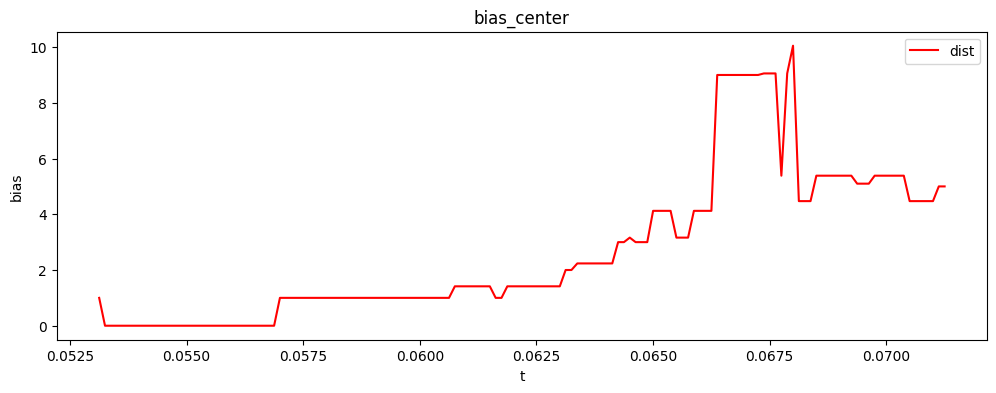

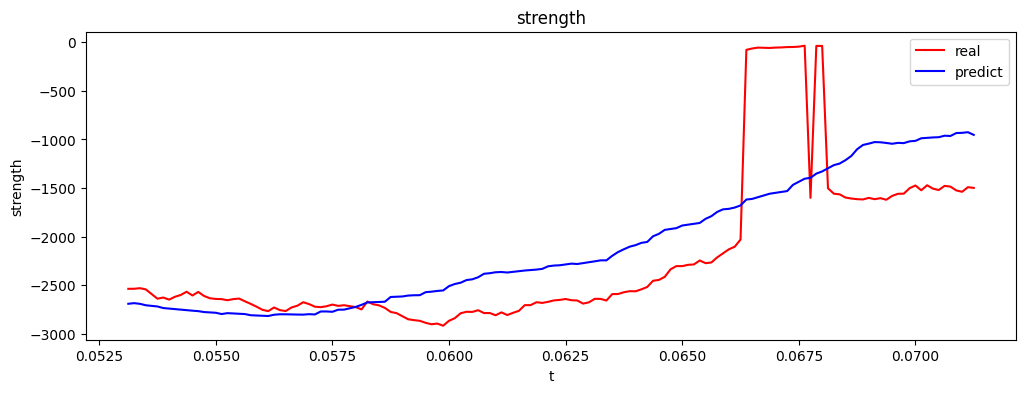

round: 26
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 3708.733 1 + 178.143 Vx + -2.530 Vy + -120819.838 t + -14.510 VxVx + -86.873 VyVy + 983129.149 tt + -40.107 VxVy + -2597.112 Vxt + 515.776 Vyt + -0.638 VxVxVy + 247.906 VxVxt + 1494.386 VyVyt + 522.953 VxVyt + 5327.585 Vx_2 + -2434.553 Vy_2 + 437.717 Vx_1 + -2627.997 Vy_1 + -99.309 VxVx_2 + 385.775 VxVy_2 + -169833.162 Vxt_2 + 17.510 VyVx_2 + 39.354 VyVy_2 + 1355394.010 Vyt_2 + 61.002 tVx_2 + 1234.500 tVy_2 + -7667.825 tt_2 + 1.538 VxVxVx_2 + -385.137 VxVxVy_2 + -693.555 VxVxt_2 + -768.267 VyVyVx_2 + -496.748 VyVyVy_2 + -142.910 VyVyt_2 + 80676.665 ttVx_2 + 18.987 ttVy_2 + -0.160 ttt_2 + -659805.970 VxVyVx_2 + -40.164 VxVyVy_2 + 9201.970 VxVyt_2 + 2195.124 VxtVx_2 + -0.183 VxtVy_2 + -403.628 Vxtt_2 + 9.738 VytVx_2 + 825.689 VytVy_2 + -97.724 VxVx_1 + -499.929 VxVy_1 + -9042.852 Vxt_1 + 53.479 VyVx_1 + 139.101 VyVy_1 + 33258.950 Vyt_1 + -23.612 tVx_1 + 1355.265 tVy_1 + 6224.391 tt_1 + 1.614 VxVxVx_1 + -883.967 VxVxVy_1 + -1894.690 VxVxt_1 

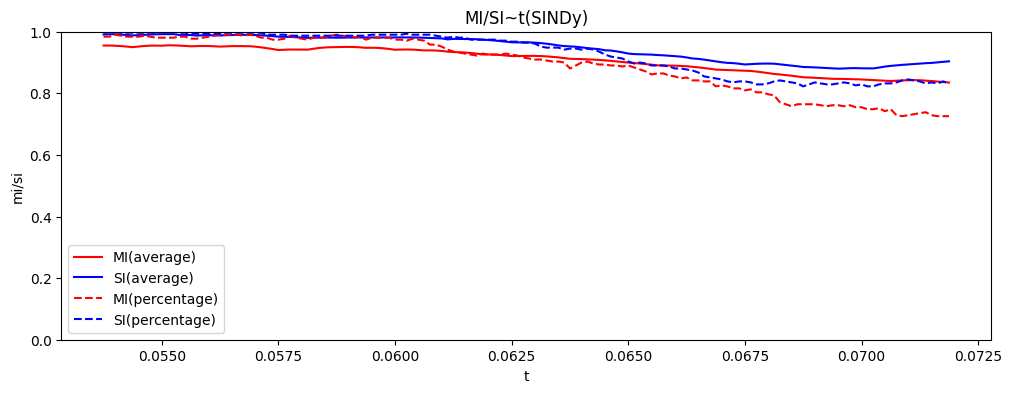

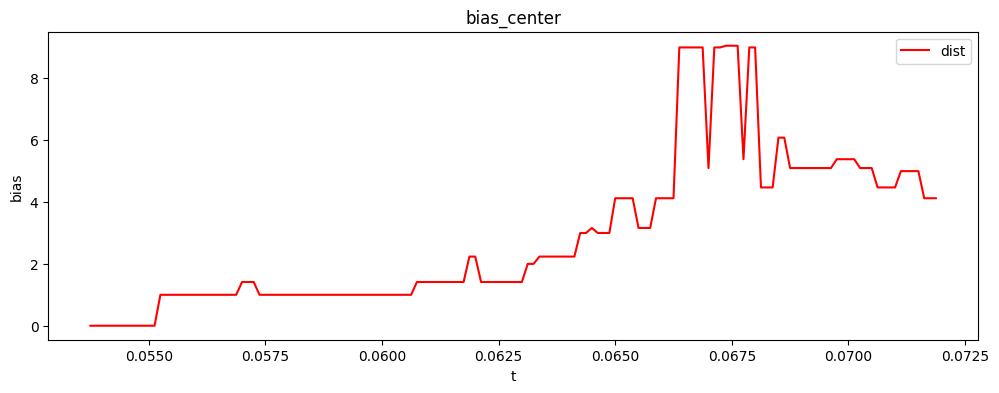

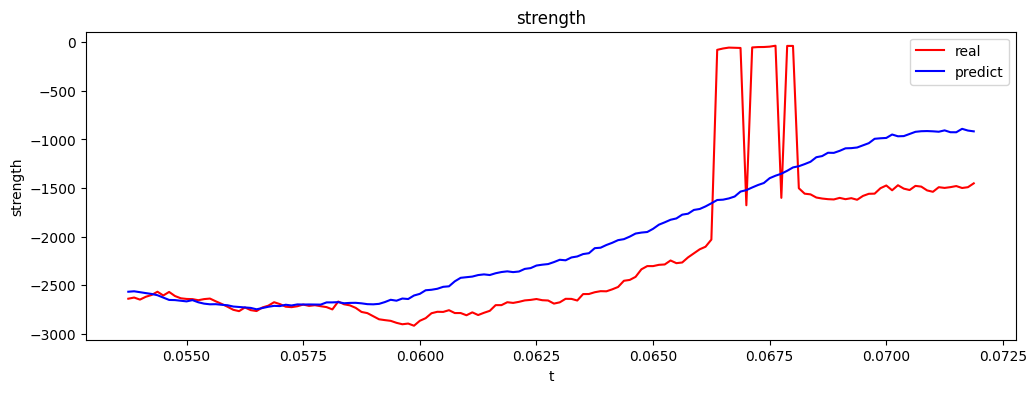

round: 27
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 4993.510 1 + 240.367 Vx + -2.472 Vy + -161434.926 t + -11.414 VxVx + -71.924 VyVy + 1302345.991 tt + -54.738 VxVy + -3539.948 Vxt + 486.050 Vyt + -0.991 VxVxVy + 191.899 VxVxt + 1266.403 VyVyt + 747.457 VxVyt + 6529.985 Vx_2 + -1994.952 Vy_2 + 1683.437 Vx_1 + -3925.751 Vy_1 + -100.351 VxVx_2 + 591.354 VxVy_2 + -208133.843 Vxt_2 + 18.039 VyVx_2 + -23.885 VyVy_2 + 1659977.967 Vyt_2 + 50.564 tVx_2 + 1224.590 tVy_2 + -10733.081 tt_2 + 1.681 VxVxVx_2 + -401.519 VxVxVy_2 + 257.997 VxVxt_2 + -626.438 VyVyVx_2 + -788.005 VyVyVy_2 + -102.984 VyVyt_2 + 67036.305 ttVx_2 + 4.439 ttVy_2 + -3.023 ttt_2 + -553761.653 VxVyVx_2 + 35.076 VxVyVy_2 + 13523.633 VxVyt_2 + 1595.040 VxtVx_2 + -0.173 VxtVy_2 + -144.385 Vxtt_2 + 51.156 VytVx_2 + -294.282 VytVy_2 + -221.624 VxVx_1 + -492.654 VxVy_1 + -48382.662 Vxt_1 + 39.890 VyVx_1 + 135.404 VyVy_1 + 343647.124 Vyt_1 + 14.032 tVx_1 + 3226.373 tVy_1 + 6018.888 tt_1 + 2.220 VxVxVx_1 + -689.553 VxVxVy_1 + -1807.514 V

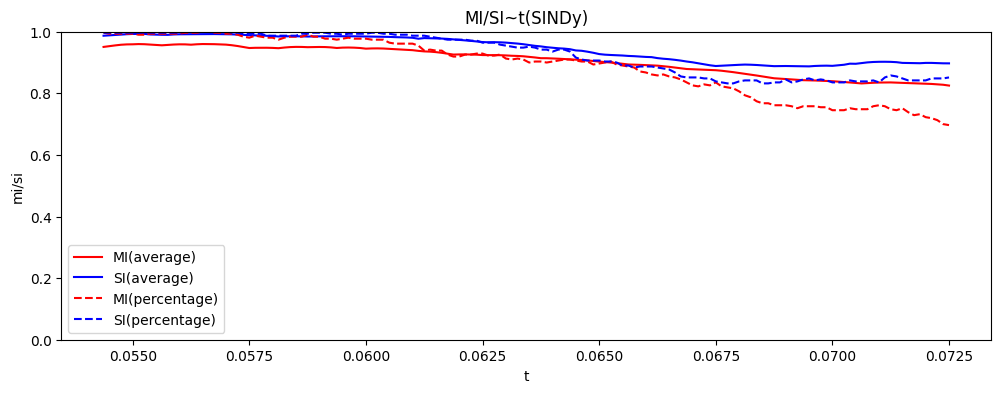

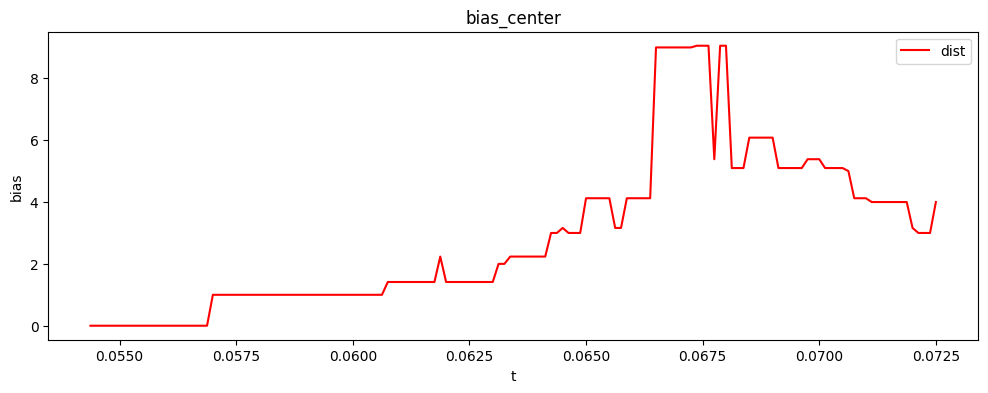

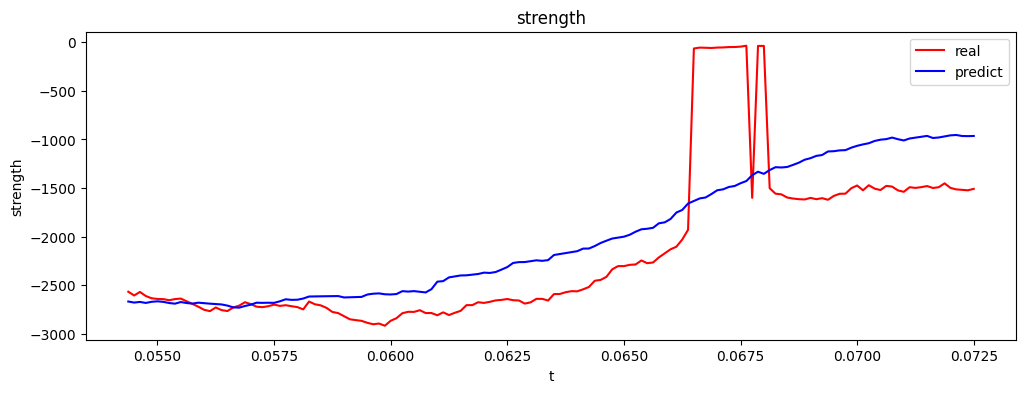

round: 28
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 4546.882 1 + 104.219 Vx + 27.097 Vy + -147065.310 t + -43.685 VxVx + -63.095 VyVy + 1188070.795 tt + -11.931 VxVy + -1517.132 Vxt + -48.771 Vyt + -0.573 VxVxVy + 694.703 VxVxt + 1110.336 VyVyt + 94.296 VxVyt + 6574.728 Vx_2 + -3089.068 Vy_2 + 1501.973 Vx_1 + -4001.101 Vy_1 + -161.758 VxVx_2 + 730.615 VxVy_2 + -210228.268 Vxt_2 + 11.328 VyVx_2 + -61.089 VyVy_2 + 1681999.753 Vyt_2 + 66.099 tVx_2 + 2163.243 tVy_2 + -12685.051 tt_2 + 1.985 VxVxVx_2 + -296.608 VxVxVy_2 + 839.451 VxVxt_2 + -865.927 VyVyVx_2 + -870.647 VyVyVy_2 + -181.558 VyVyt_2 + 103944.776 ttVx_2 + 55.563 ttVy_2 + 5.264 ttt_2 + -863208.824 VxVyVx_2 + 80.107 VxVyVy_2 + 14542.886 VxVyt_2 + 2792.127 VxtVx_2 + -0.649 VxtVy_2 + -922.639 Vxtt_2 + -71.121 VytVx_2 + -1008.851 VytVy_2 + -104.428 VxVx_1 + -429.378 VxVy_1 + -40776.387 Vxt_1 + 74.911 VyVx_1 + 95.403 VyVy_1 + 268969.297 Vyt_1 + 18.830 tVx_1 + 1439.474 tVy_1 + 5170.203 tt_1 + 1.773 VxVxVx_1 + -1215.264 VxVxVy_1 + -1188.583

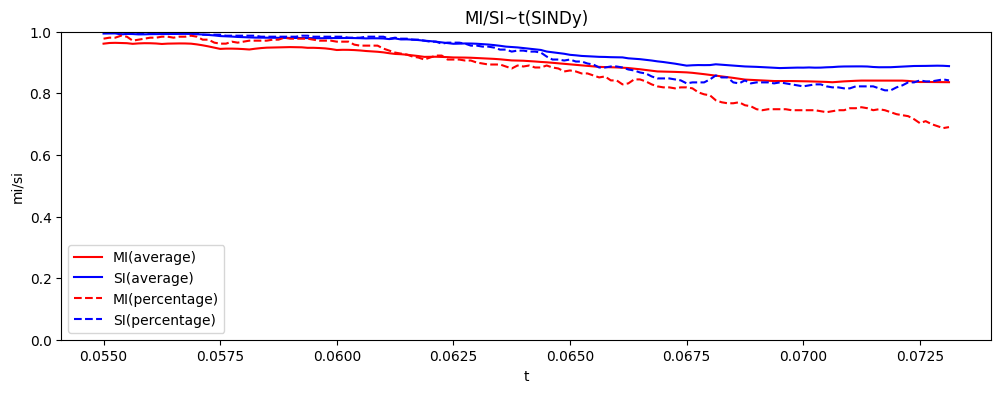

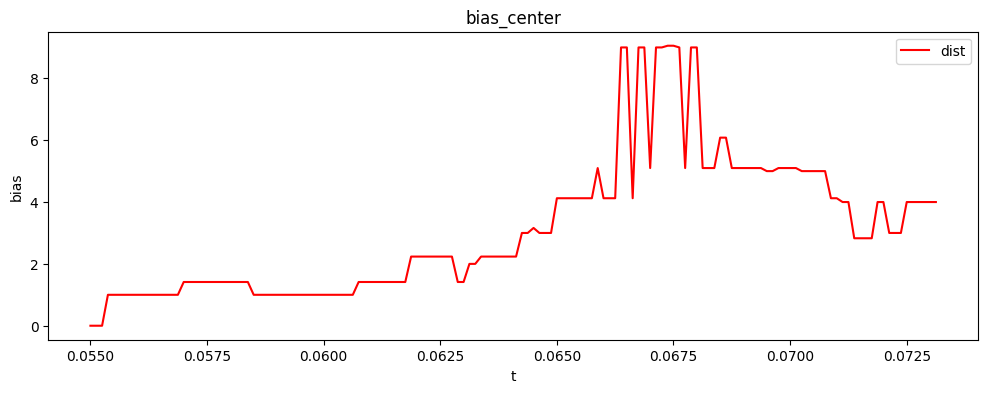

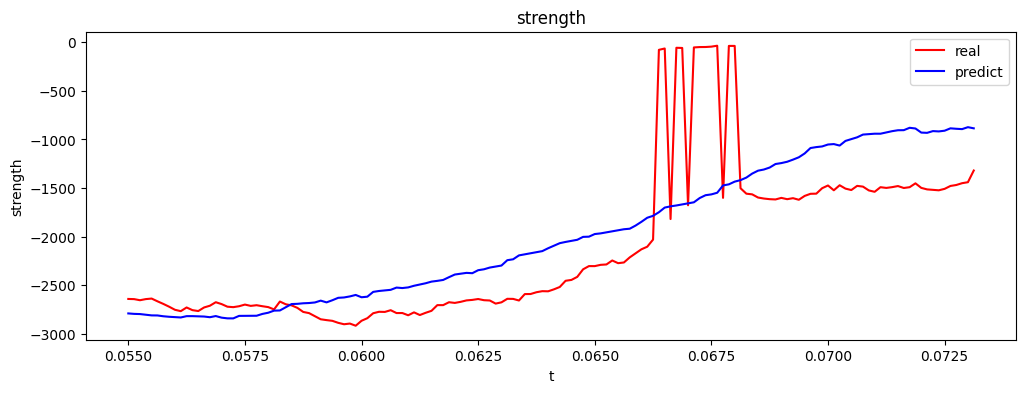

round: 29
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 4622.405 1 + 92.368 Vx + 11.163 Vy + -148586.561 t + -72.304 VxVx + -87.756 VyVy + 1193680.768 tt + -14.479 VxVy + -1380.690 Vxt + 128.824 Vyt + 0.073 VxVxVy + 1153.175 VxVxt + 1471.107 VyVyt + 126.016 VxVyt + 7381.548 Vx_2 + -5273.481 Vy_2 + 913.128 Vx_1 + -3908.379 Vy_1 + -217.537 VxVx_2 + 760.811 VxVy_2 + -234990.637 Vxt_2 + 6.161 VyVx_2 + -42.764 VyVy_2 + 1872208.005 Vyt_2 + 116.465 tVx_2 + 2988.277 tVy_2 + -12969.797 tt_2 + 2.071 VxVxVx_2 + -218.677 VxVxVy_2 + 580.526 VxVxt_2 + -1654.453 VyVyVx_2 + -960.207 VyVyVy_2 + -257.178 VyVyt_2 + 173540.421 ttVx_2 + 39.646 ttVy_2 + 9.460 ttt_2 + -1416336.492 VxVyVx_2 + 65.352 VxVyVy_2 + 15772.879 VxVyt_2 + 3930.074 VxtVx_2 + -1.086 VxtVy_2 + -648.997 Vxtt_2 + -127.190 VytVx_2 + -823.044 VytVy_2 + -253.920 VxVx_1 + -413.588 VxVy_1 + -22097.895 Vxt_1 + 43.772 VyVx_1 + 142.641 VyVy_1 + 121037.911 Vyt_1 + 52.599 tVx_1 + 3578.584 tVy_1 + 5026.765 tt_1 + 1.820 VxVxVx_1 + -748.711 VxVxVy_1 + -1880.41

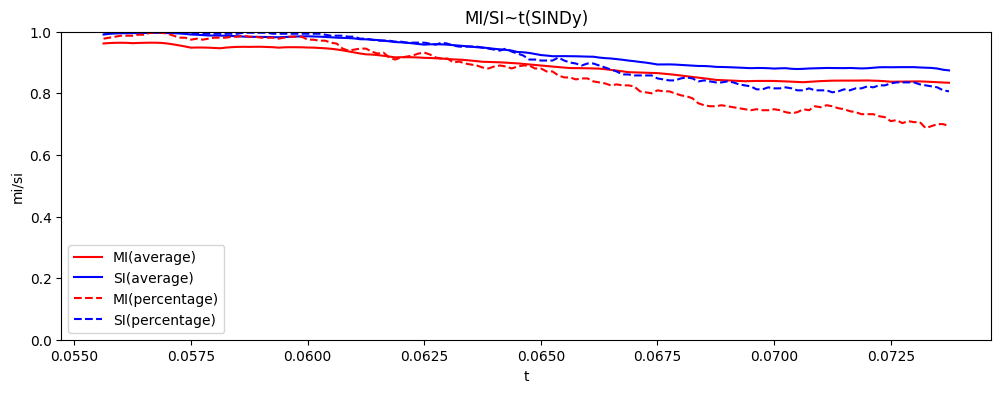

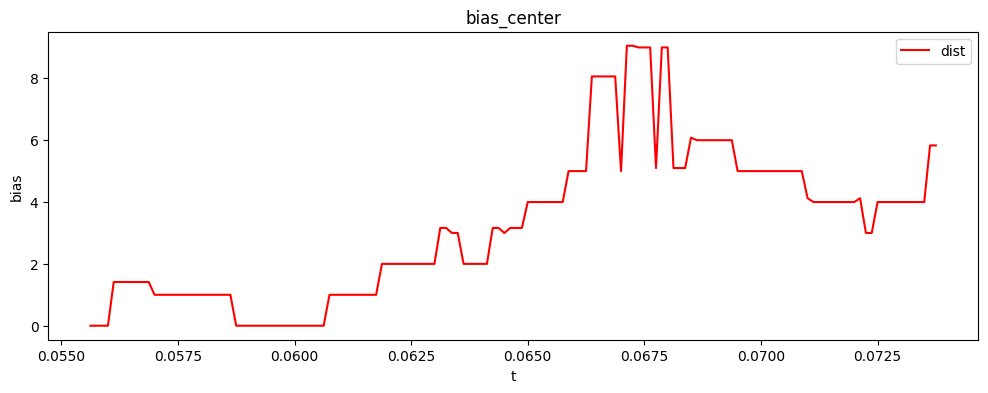

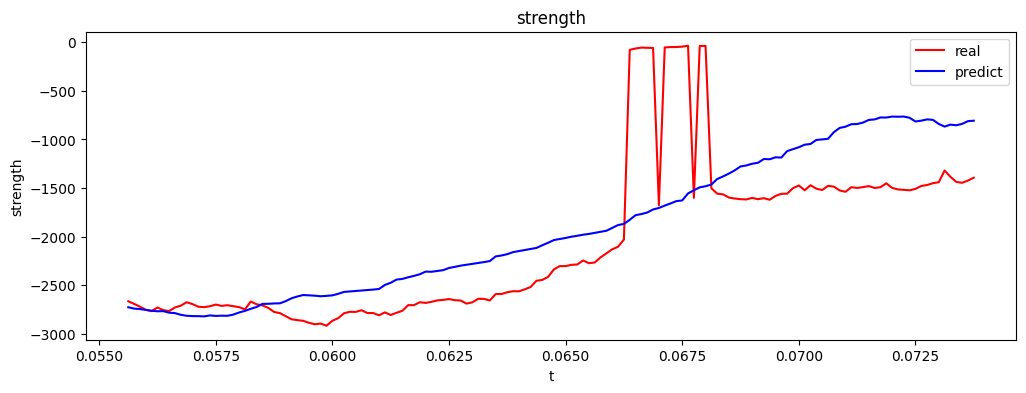

In [6]:
left_bond=60
test_range=30
good_time=np.zeros(test_range)

v_train=np.zeros((n,n,p_tot,3))
t_train=np.zeros(p_tot)
v_test=np.zeros((n,n,p_tot,3))



for k in range(test_range):
    print('round:',k)
    startp=left_bond+k
    endp=left_bond+k+dp
    v_train=u_train[:,:,startp*addp:(endp-1)*addp+1]   
    t_train=v_train[0,0,:,2]
    
    dt_train=v_train[0,0,1,2]-v_train[0,0,0,2]
    
    
    v_test=u_test[:,:,startp*addp:(endp-1)*addp+1]
    
    print(v_train.shape)
    print(t_train.shape)
    
    
    '''
    np.save('v_train.npy',v_train)
    np.savetxt('v_train_dot.txt',v_train_dot)
    np.savetxt('t_train.txt',t_train)
    '''
    model=getmodel(v_train,spatial_grid, dt_train)
    
    x_dot_test_predicted = model.predict(v_test)
    x_dot_test_predicted=x_dot_test_predicted.reshape(n,n,p_tot,3)
    tlen=p_tot
    dot_tmp=np.array(x_dot_test_predicted)
    pltpredict=np.zeros((n,n,tlen,2))
    #print(dot_tmp[10,10])

    
    pltpredict[:,:,0]=v_train[:,:,0,:2]
    for i in range(tlen-1):
        pltpredict[:,:,i+1]=pltpredict[:,:,i]+dot_tmp[:,:,i,:2]*dt_train

    map_num=p_tot
    center=np.zeros((p_tot,6))
    
    strength=np.zeros((map_num,2))
    bias_center=np.zeros(map_num)
    
    for i in range(p_tot):
        j=i
        mi_t[i],mi_t_per[i]=miscore(pltpredict[:,:,j,],v_test[:,:,j,:])
        si_t[i],si_t_per[i]=siscore(pltpredict[:,:,j,],v_test[:,:,j,:])
        center[j],bias_center[j],strength[j] = cmp_center(v_test[:,::-1,j,0].T,v_test[:,::-1,j,1].T,pltpredict[:,::-1,j,0].T,pltpredict[:,::-1,j,1].T,n)
        if mi_t_per[i]>0.8 and si_t_per[i]>0.8:
            good_time[k]=good_time[k]+1

        '''
        if i%(addp)==0:
            plt.figure(figsize=(16, 4))
            plt.subplot(1, 3, 1)
            plt.title('MI percetage '+str(mi_t_per[i]))
            plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],v_test[:,:,j,0],v_test[:,:,j,1],color='r',label='real')
            plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],pltpredict[:,:,j,0],pltpredict[:,:,j,1],color='b',label='predict')
            plt.legend()
            plt.subplot(1, 3, 2)
            plt.title('SI percetage '+str(si_t_per[i]))
            plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],v_test[:,:,j,0],v_test[:,:,j,1],color='r',label='real')
            #plt.quiver(spatial_grid[:,:,1],spatial_grid[:,:,0],pltpredict[:,:,i,0],pltpredict[:,:,i,1],color='b')
            plt.legend()
            plt.subplot(1, 3, 3)
            #plt.quiver(spatial_grid[:,:,1],spatial_grid[:,:,0],u_dot_train[:,:,i+1,0],u_dot_train[:,:,i+1,1],color='r')
            plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],pltpredict[:,:,j,0],pltpredict[:,:,j,1],color='b',label='predict')
            plt.legend()
            plt.show()
        '''
    
    plt.figure(figsize=(12, 4))
    plt.title('MI/SI~t(SINDy)')
    plt.ylim(0,1)
    plt.xlabel('t')
    plt.ylabel('mi/si')
    plt.plot(t_train,mi_t,'r',label='MI(average)')
    plt.plot(t_train,si_t,'b',label='SI(average)')
    plt.plot(t_train,mi_t_per,'r--',label='MI(percentage)')
    plt.plot(t_train,si_t_per,'b--',label='SI(percentage)')
    plt.legend()
    plt.ylim(0.0, 1)
    plt.plot
    plt.show()

    plt.figure(figsize=(12, 4))
    plt.title('bias_center')
    #plt.ylim(0,1)
    plt.xlabel('t')
    plt.ylabel('bias')
    plt.plot(t_train,bias_center,'r',label='dist')
    
    plt.legend()
    #plt.ylim(0.5, 1)
    plt.plot
    plt.show()
    
    plt.figure(figsize=(12, 4))
    plt.title('strength')
    
    plt.xlabel('t')
    plt.ylabel('strength')
    plt.plot(t_train,strength[:,0],'r',label='real')
    plt.plot(t_train,strength[:,1],'b',label='predict')
    
    plt.legend()
    
    plt.show()
    
    good_time[k]=good_time[k]/addp



fit_time: [29.2 29.2 29.2 29.2 29.2 29.2 29.2 29.2 29.2 29.2 29.2 29.2 29.2 29.2
 29.2 29.2 29.2 29.2 29.2 29.2 29.2 29.  29.2 27.  25.  24.  22.8 22.
 20.6 19.4]


<function matplotlib.pyplot.show(close=None, block=None)>

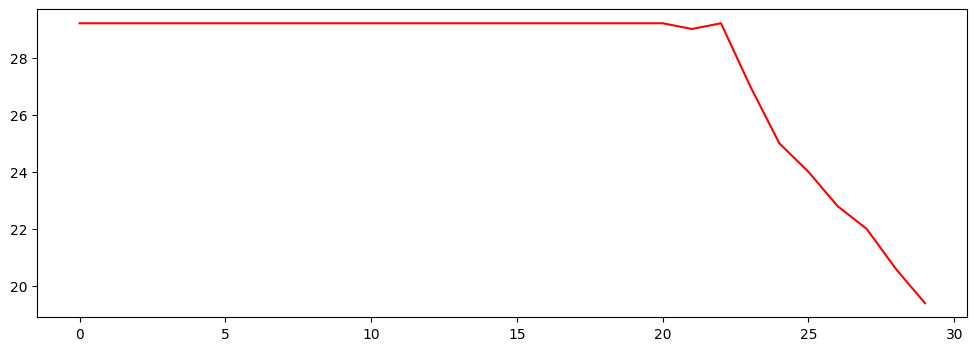

In [7]:
print('fit_time:',good_time)
plt.figure(figsize=(12, 4))
plt.plot(range(test_range),good_time,'r')
plt.show